# Intro
В этом проекте мы предсказываем стоимость автомобиля на вторичном рынке по табличным данным. Задача регрессии. Метрика - MAPE, абсолютное процентное отклонение. Кроме самого предсказания цены, интерес представляет то, какие характеристики в какой степени оказывают влияние на цену автомобиля

Расскажу коротко про основные этапы моей работы над проектом - чтобы в случае, если я удалю какие-то ячейки, оказавшиеся бесполезными, не складывалось впечатления, что я просто загрузила датасет, обучила на нем бустинг из коробки и получила результат. А еще потому, что это было увлекательно

1. **EDA**. Стандартно начинаем с рассмотрения данных. Смотрим на таблицы и графики, оценивая направления и объем будущей предобработки. Я смотрела распределение отдельных признаков, их связь с ценой, целевым признаком, и линейные корреляции между количественными признаками (проверка на мультиколлинеарность)

2. **Preprocessing**. В датасете довольно много неявных дубликатов. По рекомендации Тимлида я ознакомилась с методом Левенштейна и использовала его, чтобы почистить категориальные столбцы. Я не удаляла из набора выбросы (наверное, можно было бы). Для заполнения пропусков я использовала свой ранее написанный sklearn-совместимый кастомный импьютер. Он вставляет среднее значение по группе, в данном случае по модели автомобиля. Это была отличная возможность обкатать импьютер и исправить возникшие проблемы

3. **Разбивка датасета на две отдельные модели**. Я отделила от основного, более-менее качественного набора, наблюдения, в которых было много пропусков и/или не указана марка-модель. На этом этапе казалось оправданным работать с этими выборками отдельно, но в конце я отказалась от такого подхода

4. **Baseline**. Я взяла за основу простую линейную регрессию. Она показала довольно высокую ошибку (mape от 48 до 53). Ее же я использовала для тестирования новых признаков, когда добавляла их

5. **Feature engineering**. Я посчитала прогнозную цену простой линейной регрессией по трем количественным признакам, которые кажутся самыми важными: год выпуска, пробег, состояние. Результат этого расчета добавила в датасет как признак. Из даты продажи извлекла год и месяц. Добавила возраст авто на момент продажи и среднегодовой пробег. Среднюю цену по модели - этот признак мне не очень нравится, по-моему, в нем утечка, ведь в среднюю цену потенциально входит цена самого наблюдения. На тесте у нас такой информации не будет и это чревато большим расхождением метрики между обучающей и тестовой выборками. Не в пользу последней. Наконец, я сделала кластеризацию kmeans для моего "хорошего" набора и взяла это в качестве признака. "Плохой" набор при объединении выделила в еще один кластер. При добавлении все признаки проверяла все той же линейной регрессией, метрика каждый раз едва заметно улучшалась. Явно не работали только признак количества экземпляров модели в датасете (его удалила, интуитивно я тоже вижу в нем мало смысла) и, почему-то, средняя цена модели

6. **Этап, который не получился**. Здесь я хотела первым делом добавить регрессии регуляризацию, а потом попробовать еще несколько классических моделей. На подобной задаче у меня как-то хорошо показывал себя KNN, хотя в целом это не очень сильный алгоритм. Случайный лес - ради его feature_importances_ и потому, что по результату он, как правило, уступает только бустингу. Но ни один алгоритм мне не удалось дождаться. Датасет немаленький - 440 тысяч. Признаков после кодирования OHE получается чудовищно много. Неудивительно, что даже Лассо регрессия не считается за полтора часа. Какие есть варианты? Ordinal Encoder для этой задачи я не считаю корректным. Сократить число категорий я пыталась. Я объединила все уникальные значения, встречающиеся меньше 10 раз, в категорию "другое". Количество сократилось примерно на треть, но время работы алгоритмов приемлемым так и не стало. Сокращать еще или вовсе оставить только количественные признаки - это настолько компромисс и потеря качества, что нужна ли такая модель вообще? (например, без знания марки и модели при равном пробеге, состоянии и годе выпуска kia rio и bentley continental будут оцениваться одинаково). Тогда я приняла, очевидно незрелое, решение - перейти сразу к бустингам. Все равно этим закончим. Кроме того, бустинг для такой задачи кажется идеальным и необходимым: он быстр, справляется с большими объемами и сам обрабатывает категории (при обучении кстати, бустинг ввели на похожей задаче, когда все более простые модели показали себя плохо)

7. **Gradient boosting**. На датасете со всеми добавленными признаками я обучила LightGBM регрессор. Результат на тестовой выборке - 35. Тогда я обучила его на сыром датасете из файла и получила 15. Цифры указывают на то, что вся проделанная работа не имела смысла. Я попробовала еще Catboost, на обработанном наборе, он показал 45 и считался долгие полчаса против пары минут LGBM. На сыром датасете его не обучить - он не принимает пропуски. На этом я Катбуст оставила

8. **Investigation**. Мне казалось, что хоть что-то из моих наработок можно использовать, чтобы еще улучшить и так неплохой дефолтный результат. И понять, что так сильно портит мой основной результат. Я рассмотрела feature_importances неудачной модели - на первом месте с отрывом оказался продавец, явно вторичный признак. Удалила продавца в надежде, что модель найдет правильные ориентиры - и она вместо этого догнала Катбуст, показав mape=45. Я зашла с другой стороны и стала добавлять признаки по одному к дефолтной модели. Сначала расчетную цену, полученную от линейной регрессии. Mape=46... Судя по всему, этот признак и портил модель, забирая довольно большой вес и приводя к большой ошибке. Кластер окзался просто маловажным признаком. Все остальные я по одному добавила в модель, постепенно улучшая ее и попутно оптимизируя Optun'ой. Таким образом вышла на mape=13. Наиболее значимые признаки в итоговой модели - это


# Imports and files upload

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgbm
from catboost import CatBoostRegressor
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.visualization.matplotlib import plot_param_importances

In [3]:
# Load files
train = pd.read_csv('train.csv', parse_dates=[14])
test = pd.read_csv('test.csv', parse_dates=[13])
samplesubmission = pd.read_csv('sample_submission.csv')

In [4]:
def review(df):
    print('Строк в датафрейме:', df.shape[0])
    print('Столбцов в датафрейме:', df.shape[1])
    display(df.head())
    display(df.info())
    display(df.isna().agg(['sum', 'mean']).transpose().sort_values(by='mean', ascending=False))
review(train)

Строк в датафрейме: 440236
Столбцов в датафрейме: 15


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-02 02:30:00+07:00
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-25 02:00:00+08:00
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-10 02:30:00+07:00
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-17 03:00:00+07:00
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-03 04:00:00+08:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


None

,sum,mean
transmission,51461.0,0.116894
body,10393.0,0.023608
condition,9405.0,0.021364
trim,8337.0,0.018938
model,8123.0,0.018451
make,8043.0,0.018270
color,586.0,0.001331
interior,586.0,0.001331
odometer,69.0,0.000157
year,0.0,0.000000


In [5]:
review(test)

Строк в датафрейме: 110058
Столбцов в датафрейме: 14


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015-01-14 04:30:00+08:00
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,2015-02-27 01:00:00+08:00
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015-02-24 01:30:00+08:00
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,2015-03-06 02:00:00+08:00
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,2015-06-03 03:30:00+07:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


None

,sum,mean
transmission,13011.0,0.118219
body,2594.0,0.023569
condition,2379.0,0.021616
trim,2114.0,0.019208
model,2079.0,0.018890
make,2061.0,0.018726
color,158.0,0.001436
interior,158.0,0.001436
odometer,19.0,0.000173
year,0.0,0.000000


# EDA

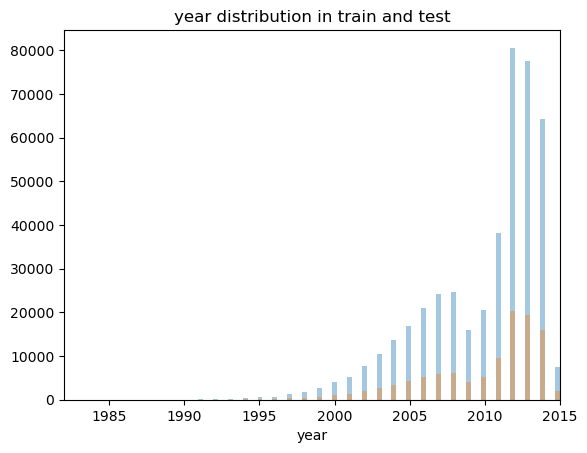

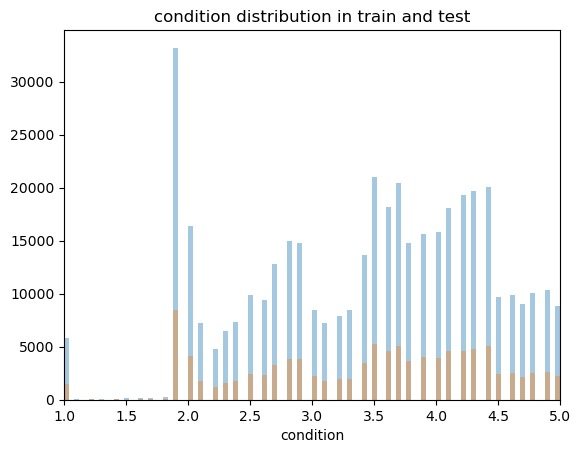

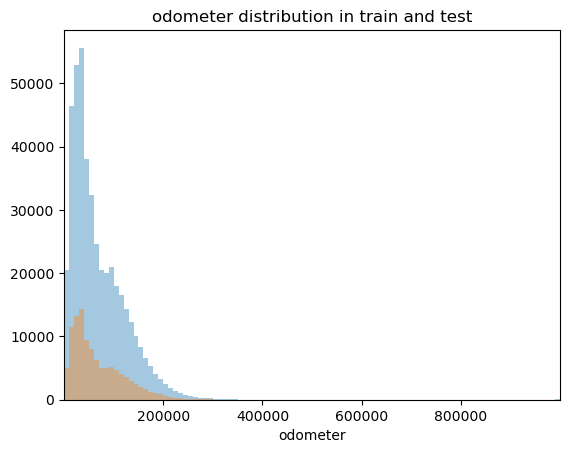

In [6]:
def numeric_train_test_hist(col_name):
    fig, ax = plt.subplots()
    for a in [train[col_name], test[col_name]]:
        min_val = int(train[col_name].min())
        max_val = int(train[col_name].max())
        sns.distplot(a, bins=100, ax=ax, kde=False)
    ax.set_xlim([min_val, max_val])
    plt.title(f'{col_name} distribution in train and test')
    
for col in ['year', 'condition', 'odometer']:
    numeric_train_test_hist(col)

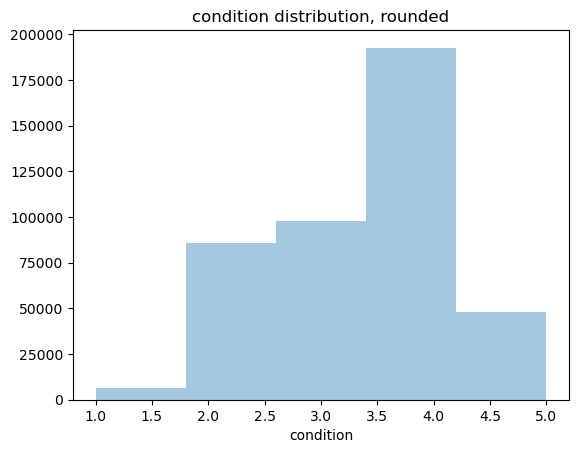

In [7]:
sns.distplot(train['condition'].round(), bins=5, kde=False)
plt.title('condition distribution, rounded');

Number of categories in make: train - 92, test - 85
Number of categories in model: train - 959, test - 824
Number of categories in trim: train - 1922, test - 1496
Number of categories in body: train - 85, test - 77
Number of categories in transmission: train - 2, test - 2
Number of categories in state: train - 38, test - 38
Number of categories in color: train - 20, test - 20
Number of categories in interior: train - 17, test - 17
Number of categories in seller: train - 13025, test - 7623


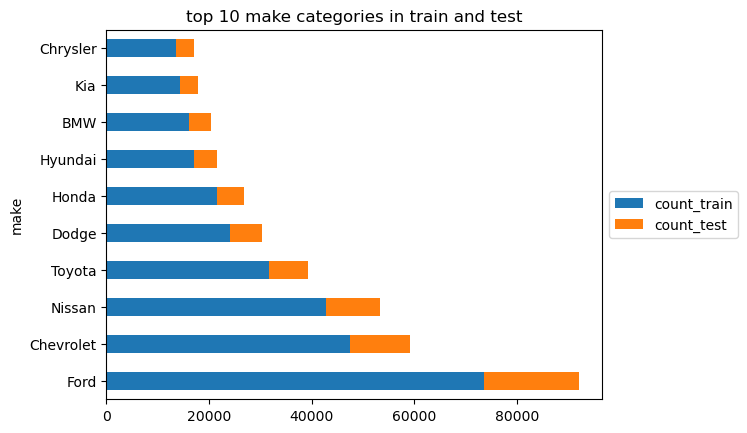

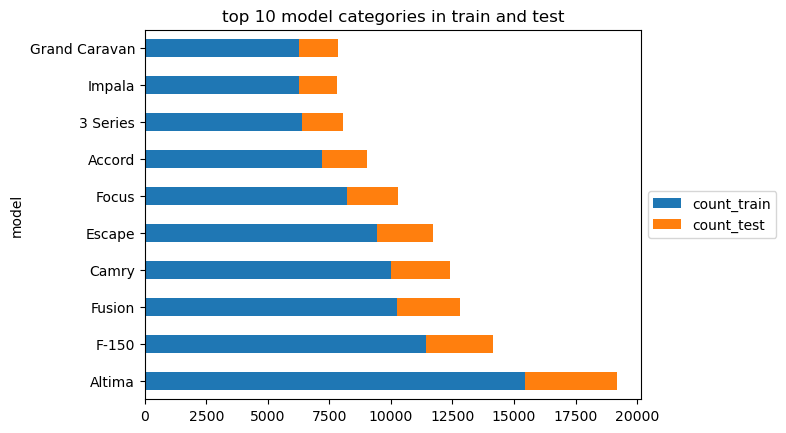

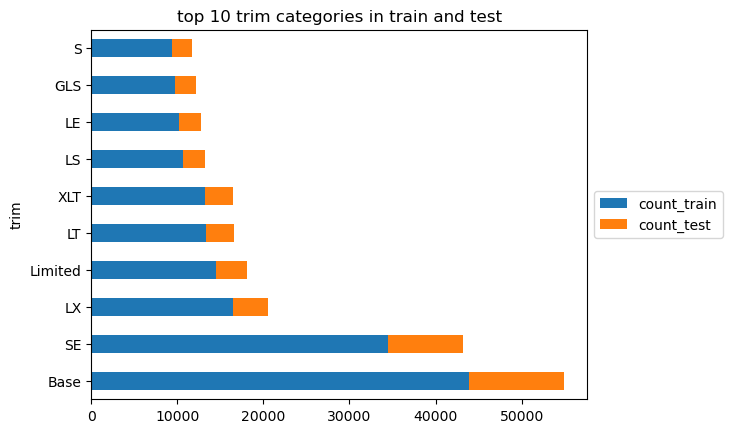

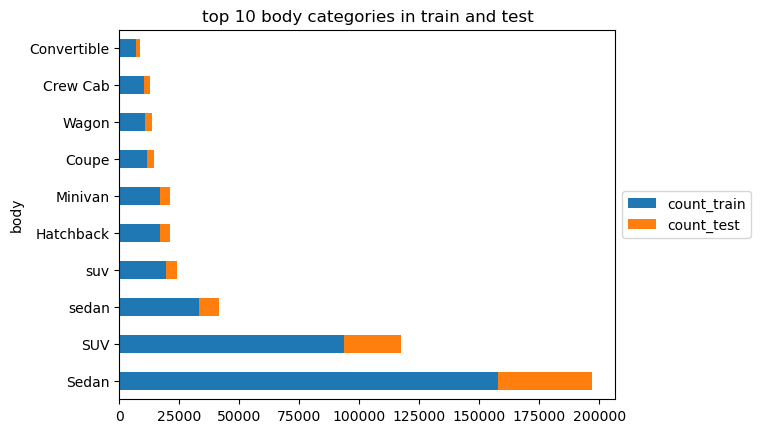

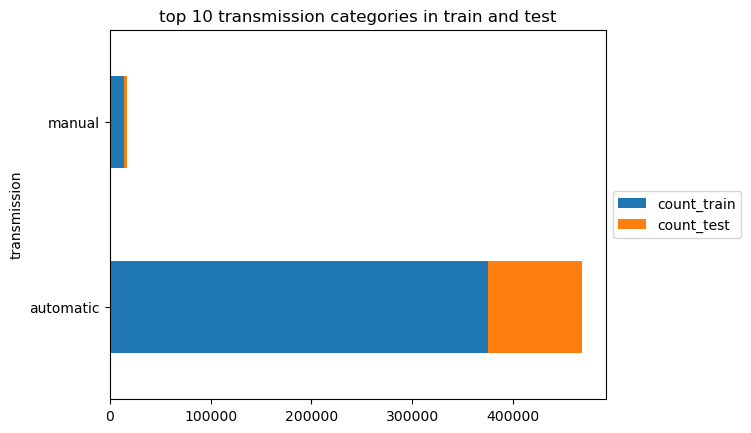

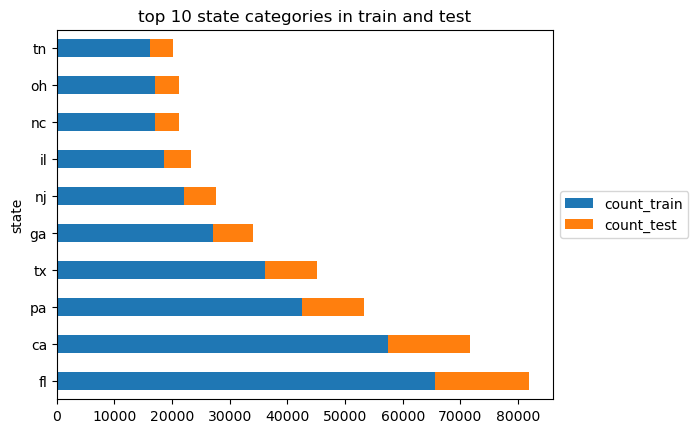

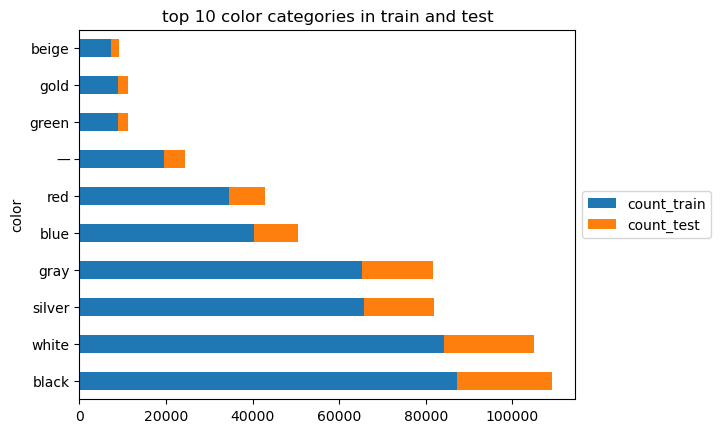

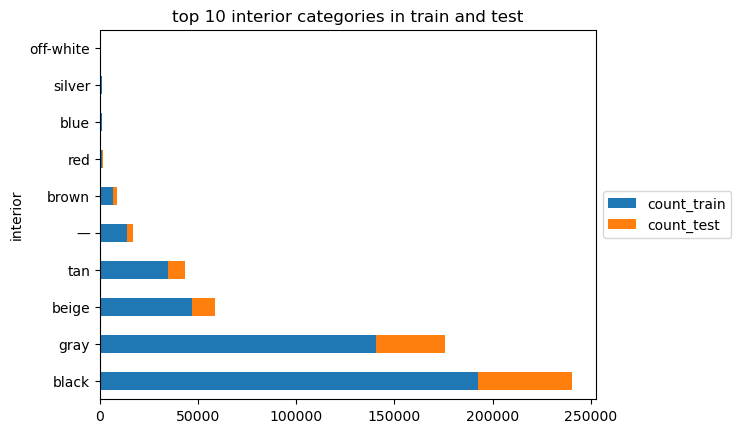

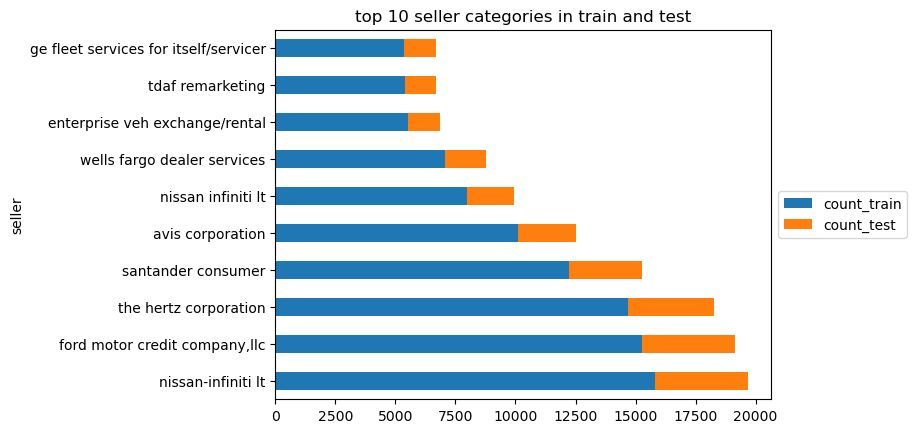

In [8]:
def categorical_train_test_hist(col_name):
    print(f'Number of categories in {col_name}: train - {train[col_name].nunique()}, test - {test[col_name].nunique()}')
    top_train = train[col_name].value_counts().reset_index().sort_values(by='count', ascending=False)
    top_test = test[col_name].value_counts().reset_index()
    top_total = top_train.merge(top_test, on=col_name, suffixes=('_train', '_test')).rename(columns={'index': col_name, (col_name+'_train'): 'train', (col_name+'_test'): 'test'})
    ax = top_total.head(10).plot.barh(x=col_name, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'top 10 {col_name} categories in train and test')
    
for col in ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']:
    categorical_train_test_hist(col)

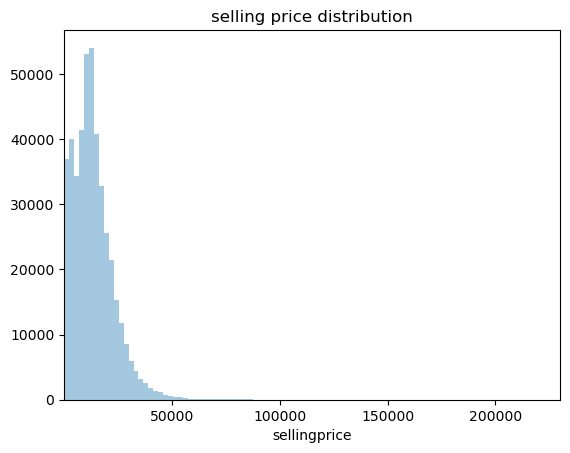

In [9]:
ax = sns.distplot(train['sellingprice'], bins=100, kde=False)
min_val = int(train['sellingprice'].min())
max_val = int(train['sellingprice'].max())
ax.set_xlim([min_val, max_val])
plt.title('selling price distribution');

In [10]:
train[train['odometer'].isna()].head(20)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
36557,2002,Ford,Windstar,LX Standard,Minivan,automatic,2fmza51442ba27119,fl,NaN,NaN,beige,tan,champion auto wholesale inc,700,2014-12-17 15:15:00+08:00
42825,1997,Toyota,Camry,CE,Sedan,automatic,4t1bg22k6vu171913,nj,NaN,NaN,gold,—,american bodywork & collision,1000,2014-12-17 09:30:00+08:00
45516,2010,NaN,NaN,NaN,NaN,automatic,1gb6g3bg6a1146243,ny,NaN,NaN,white,gray,denooyer chevrolet inc,4900,2014-12-18 12:45:00+08:00
46266,2001,Ford,Mustang,Deluxe,Convertible,automatic,1fafp44481f128016,az,NaN,NaN,white,—,chapman honda,500,2014-12-17 13:30:00+08:00
60990,2014,Ford,Fiesta,ST,Hatchback,manual,3fadp4gx4em185929,ga,4.6,NaN,black,black,carworks inc,28650,2015-03-24 02:30:00+07:00
63076,2006,NaN,NaN,NaN,NaN,manual,ja3aj16e16u070827,pr,2.1,NaN,gray,gray,oriental bank,1700,2015-06-04 04:00:00+07:00
64540,1998,Chevrolet,Blazer,LS,SUV,automatic,1gncs13wxw2254123,fl,NaN,NaN,silver,gray,coggin chevrolet at the avenues,350,2014-12-18 13:00:00+08:00
66062,2002,Ford,F-150,XL,Regular Cab,NaN,1ftrf172x2na78701,md,NaN,NaN,blue,—,sheehy ford lincoln of gaithersburg,650,2014-12-23 09:30:00+08:00
69236,2002,Toyota,Prius,Base,Sedan,NaN,jt2bk12u320041730,wa,NaN,NaN,white,—,405 motors,1200,2014-12-17 12:30:00+08:00
74432,2002,Ford,Explorer,XLT,SUV,NaN,1fmzu73e22ua05235,mn,NaN,NaN,red,—,southwest metro drug task force,2200,2014-12-18 14:00:00+08:00


In [11]:
train_na_sum = train.isna().sum(axis=1).value_counts().sort_index()
train_na_sum = (train_na_sum/train.shape[0]).round(6)

test_na_sum = test.isna().sum(axis=1).value_counts()
test_na_sum = (test_na_sum/test.shape[0]).round(6)

total_na = pd.DataFrame({'train': train_na_sum, 'test': test_na_sum})
print('Missing values by row')
total_na

Missing values by row


,train,test
0,0.845206,0.843237
1,0.130017,0.131958
2,0.005806,0.005370
3,0.000559,0.000600
4,0.015101,0.015455
5,0.003251,0.003335
6,0.000052,0.000036
7,0.000005,0.000009
8,0.000005,NaN


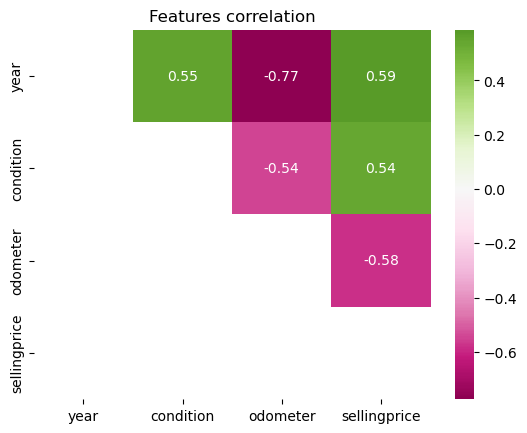

In [12]:
corr = train.corr(numeric_only=True)
corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
sns.heatmap(corr, cmap='PiYG', center=0, annot=True)
plt.title('Features correlation');

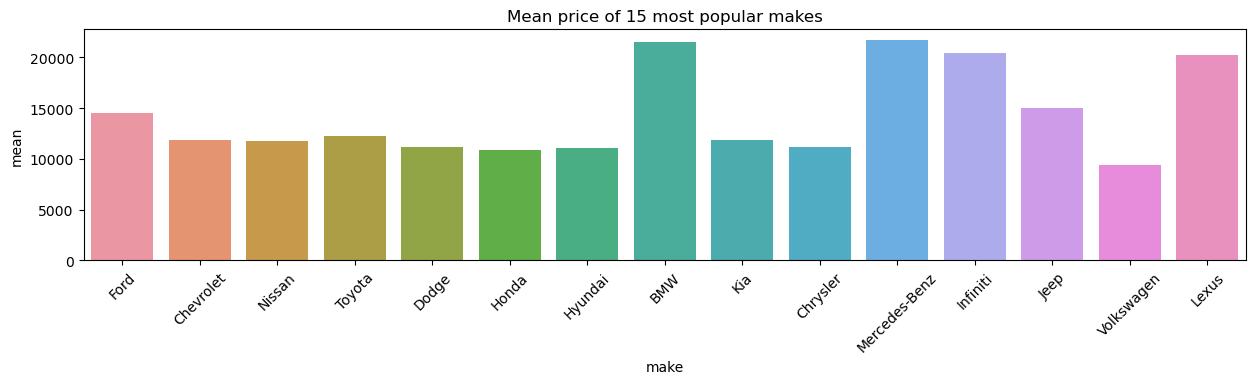

In [13]:
def categorial_barplot(col, title, sortby='count', df=train):
    grouped_by_col = df.groupby(col)['sellingprice'].agg(['mean', 'count']).sort_values(by=sortby, ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=(15, 3))
    bar = sns.barplot(grouped_by_col[:15], x=col, y='mean', ax=ax)
    bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
    plt.title(title);
    
categorial_barplot('make', 'Mean price of 15 most popular makes')

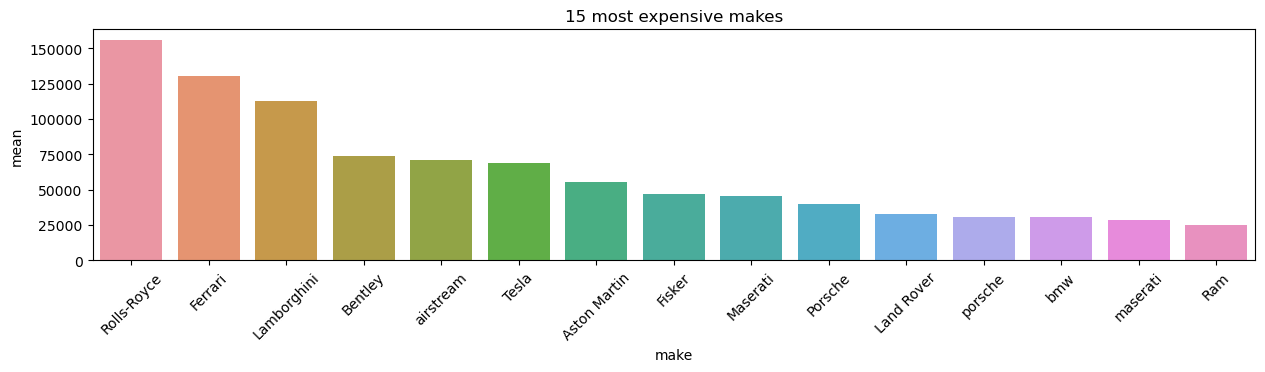

In [14]:
categorial_barplot('make', '15 most expensive makes', 'mean')

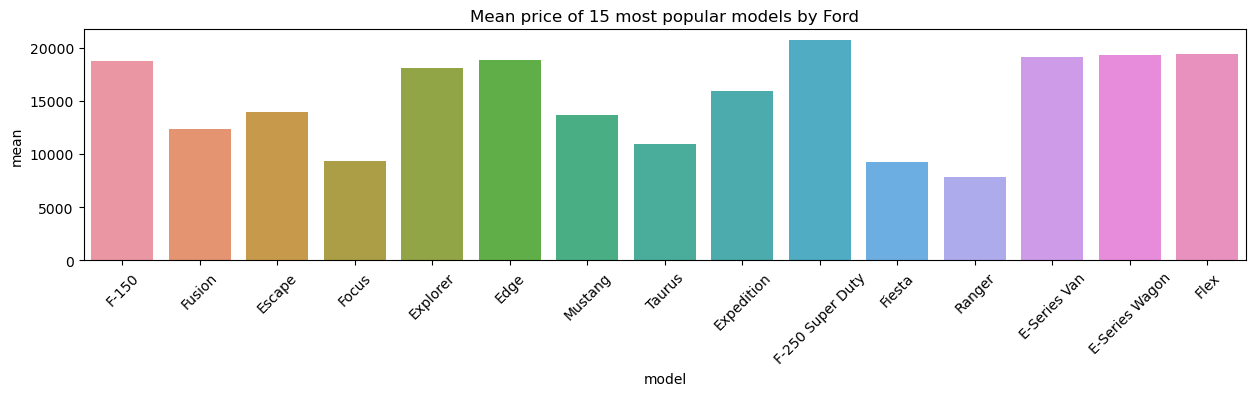

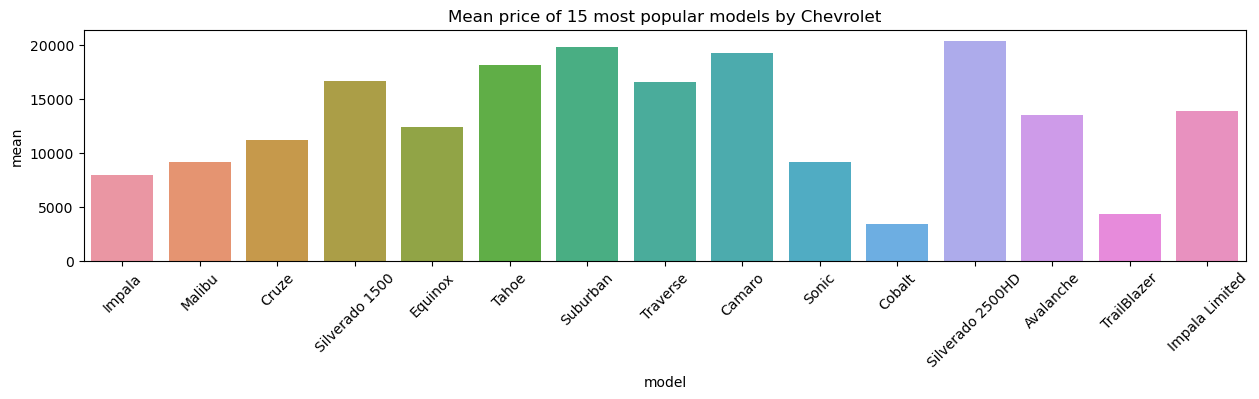

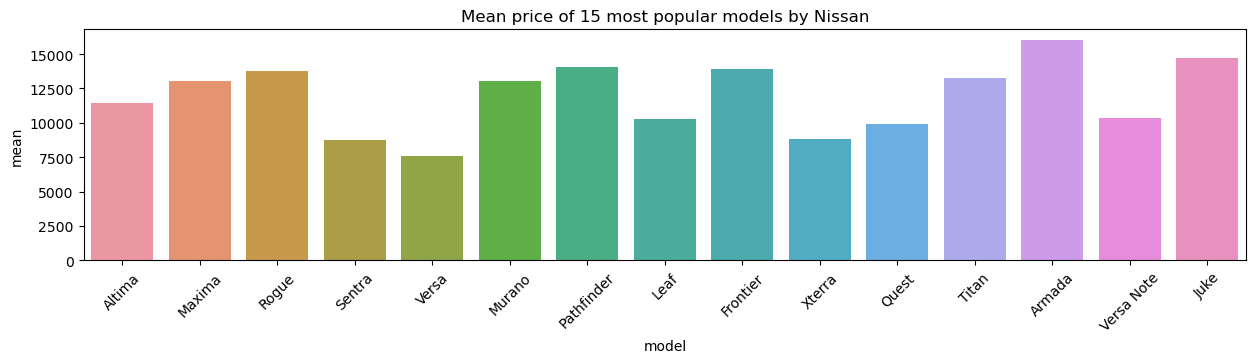

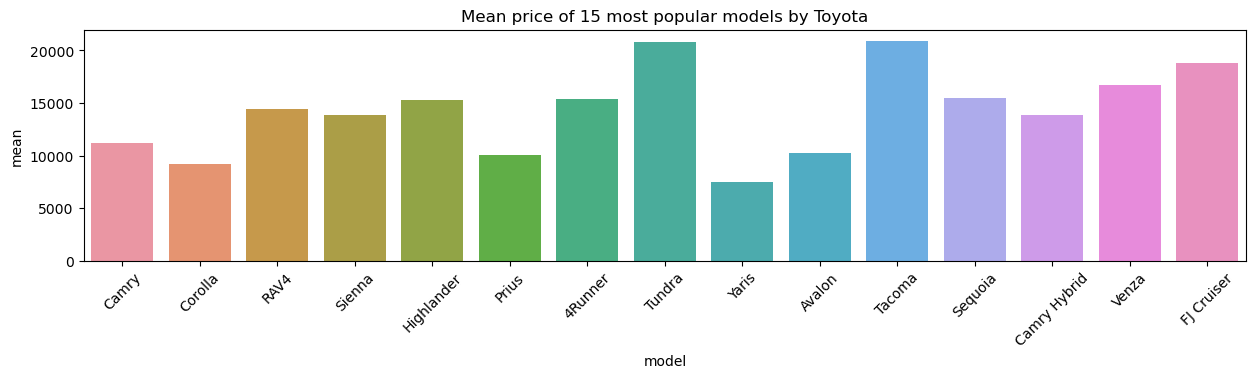

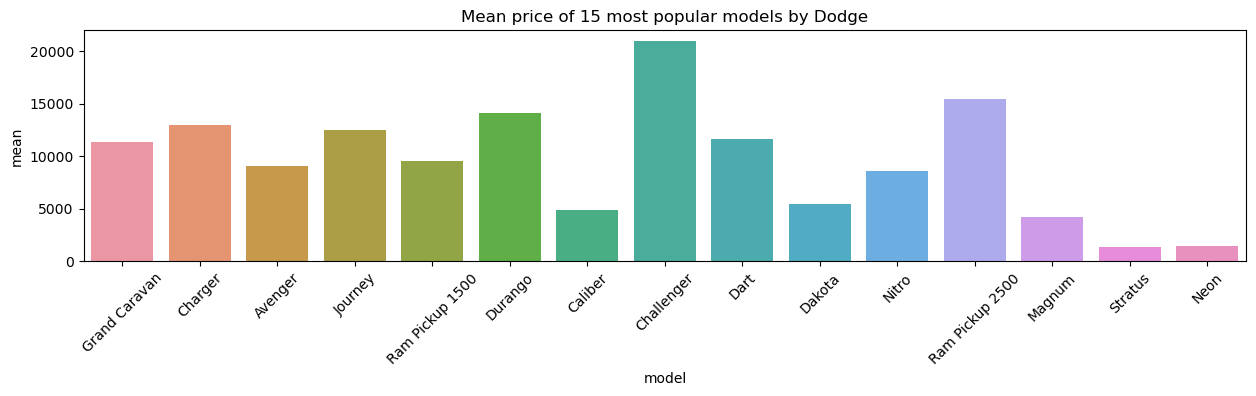

In [15]:
for make in ['Ford', 'Chevrolet', 'Nissan', 'Toyota', 'Dodge']:
    make_df = train[train['make'] == make]
    categorial_barplot('model', f'Mean price of 15 most popular models by {make}', df=make_df)

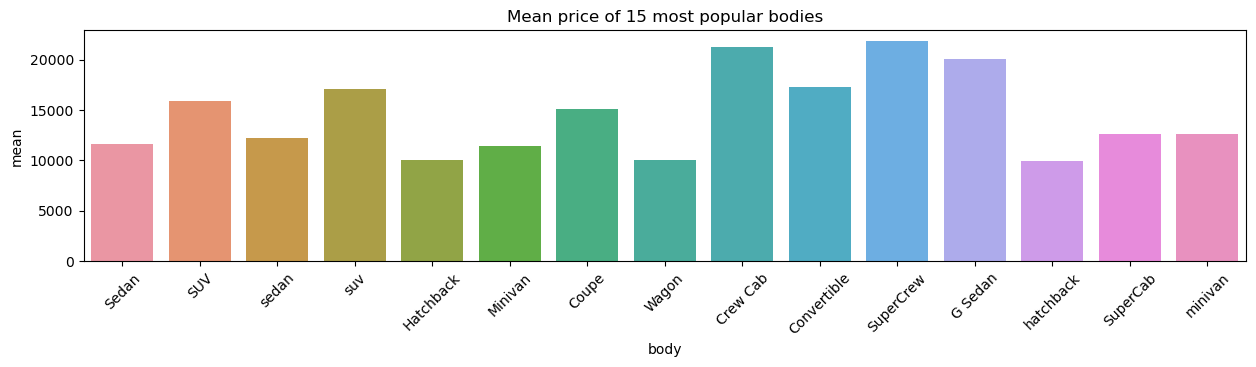

In [16]:
categorial_barplot('body', 'Mean price of 15 most popular bodies')

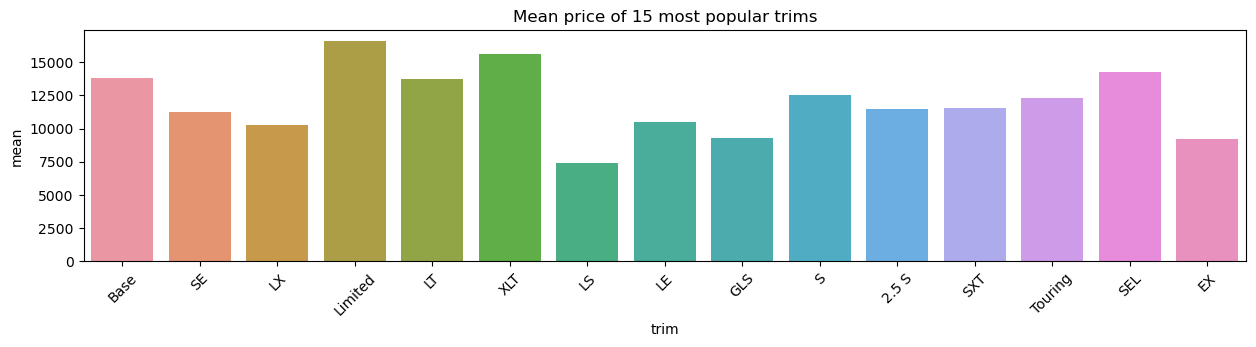

In [17]:
categorial_barplot('trim', 'Mean price of 15 most popular trims')

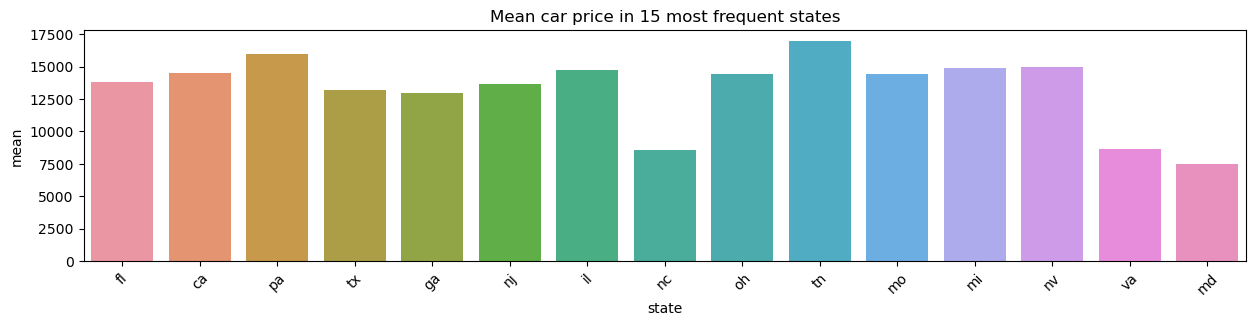

In [18]:
categorial_barplot('state', 'Mean car price in 15 most frequent states')

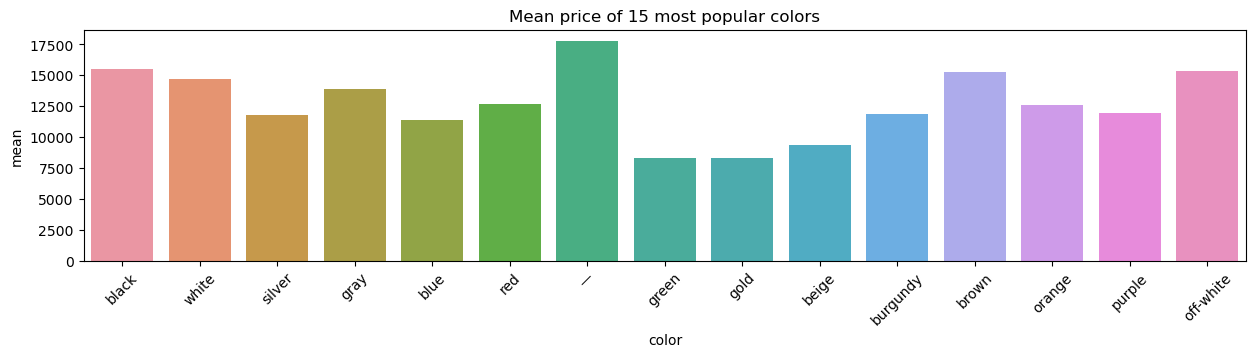

In [19]:
categorial_barplot('color', 'Mean price of 15 most popular colors')

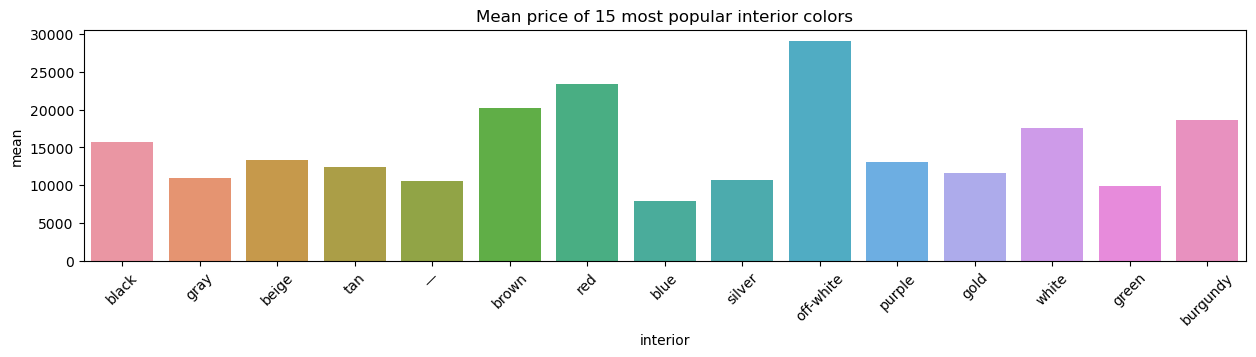

In [20]:
categorial_barplot('interior', 'Mean price of 15 most popular interior colors')

### General observations
* тестовый датафрейм по объему составляет 25% от обучающего
* кроме целевого признака (отсутствует в тесте) в датафрейме 14 столбцов
* два признака имеют формат int: год выпуска авто и цена продажи
* два признака в формате float: оценка состояния авто и пробег. Последний по смыслу целочисленный, но, я полагаю, не переводится в int из-за пропусков
* доля пропущенных значений по столбцам на первый взгляд идентична для обучающей и тестовой выборок
* более половины признаков содержат пропущенные значения, от 0.02% до 12%
* по графикам распределений видно, что тестовая выборка повторяет паттерны обучающей
* на графиках категориальных признаков видны неявные дбликаты и значения в формате str, эквивалентные пропускам
* абсолютно для всех авто в трейне указана цена и дата продажи, продавец, штат, VIN и год выпуска
* в 84,5% наблюдений нет пропусков. Порядка 98% строк имеют не более двух пропусков. Я бы рассмотрела вариант не использовать для обучения данные, где отсутствует 3 и более признака
### Selling price
* график скошен справа: большинство автомобилей недорогие, но есть небольшое число очень дорогих выбросов
* если рассматривать только количественные признаки, у них всех достаточно высокая корреляция с ценой и между собой. Чем автомобиль старше, тем больше пробег и ниже цена. Чем больше пробег, тем хуже состояние. Чем лучше состояние, тем выше цена. Это кажется очевидным
### Year
* распределение не похоже на нормальное. График скошен слева: новые автомобили преобладают над старыми
### Odometer
* пробег подтверждает это наблюдение. График скошен справа. Свежие авто с маленьким пробегом активнее продаются, чем старые с большим пробегом
* в этом столбце совсем мало пропусков, что позволяет все их просмотреть. Это разные автомобили по цене, году выпуска и состоянию. Не вижу закономерностей
### Condition
* так же не похоже на нормальное распределение. Ближе к uniform, но с большими колебаниями. Преобладают оценки от 3,5 до 4,5. Мало оценок от 1 до 2
* при округлении распределение больше похоже на нормальное с пиком в 4, но сложно судить об этом с уверенностью - значений слишком мало
* порядка 2% пропусков
### Make and model
* в обучающей выборке 92 марки и 959 моделей. В тесте несколько меньше. Можно объединить - получится один столбец с количеством категорий по числу моделей, но для OHE это в любом случае слишком много
* порядка 2% пропусков
* мы посмотрели на средние цены по маркам. В топ 15 наиболее популярных марок выделяются 5 более дорогих: BMW, Mersedes-Benz, Infiniti, Jeep и Lexus. Но ни одна из них не входит в топ 7 по количеству продаж. Автомобили со средней ценой продаются чаще
* самая дорогая марка, Rolls-Royce, в среднем в 10 раз дороже самой продаваемой, Ford
* средние цены по моделям в рамках одной марки тоже ожидаемо отличаются
### Trim
* 1922 варианта комплектаций. Вероятно, эти категории уникальны для отдельных моделей. Базовый лидирует с небольшим отрывом от SE
* порядка 2% пропусков
### Body
* 85 вариантов корпуса. Возможно, удаление дубликатов поможет немного уменьшить. В лидерах седан и SUV
* порядка 2% пропусков
### Transmission
* Механика и автомат. Автомат сильно преобладает
* максимальная доля пропусков - 11,5%
### State
* 38 штатов. Больше всего продаж во Флориде, Калифорнии и Пенсильвании
### Color and interior
* 20 цветов для кузова и 17 для салона, включая неопределенный. Лидирует черный
* порядка 0.1% пропусков
* автомобили, у которых не указан цвет, в среднем дороже всех цветных вариантов
* белый, красный и коричневый салон характерны для дорогих авто
### Seller
* более 13 тысяч продавцов. Пока кажется, что проще избавиться от этого признака, чем почистить от дубликатов и кодировать. Но этот признак может быть информативным. Например, какой-то продавец может быть крупным, иметь хорошую репутацию и давно быть на рынке - его цены будут систематически выше


# Preprocessing. Duplicates

In [21]:
# turn all the categories to lowercase
for col in train.columns:
    if train[col].dtype == 'O' and col != 'saledate':
        train[col] = train[col].str.lower()
        test[col] = test[col].str.lower()
        
train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-02 02:30:00+07:00
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-25 02:00:00+08:00
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-10 02:30:00+07:00
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-17 03:00:00+07:00
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-03 04:00:00+08:00


In [22]:
from Levenshtein import distance as lev

In [23]:
def find_close_pairs(list_of_categories):
    possible_duplicates = []
    for item in list_of_categories:
        list_of_categories = np.delete(list_of_categories, 0)
        for elem in list_of_categories:
            try:
                if lev(item, elem) <= 2 and len(item) > 3:
                    possible_duplicates.append((item, elem))
            except: continue
    return possible_duplicates

find_close_pairs(train['make'].unique())

[('mercedes', 'mercedes-b'), ('land rover', 'landrover')]

In [24]:
makes = list(train['make'].unique())
makes.remove(np.nan)
sorted(makes)

['acura',
 'airstream',
 'aston martin',
 'audi',
 'bentley',
 'bmw',
 'buick',
 'cadillac',
 'chevrolet',
 'chrysler',
 'daewoo',
 'dodge',
 'dodge tk',
 'dot',
 'ferrari',
 'fiat',
 'fisker',
 'ford',
 'ford truck',
 'geo',
 'gmc',
 'gmc truck',
 'honda',
 'hummer',
 'hyundai',
 'infiniti',
 'isuzu',
 'jaguar',
 'jeep',
 'kia',
 'lamborghini',
 'land rover',
 'landrover',
 'lexus',
 'lincoln',
 'maserati',
 'mazda',
 'mazda tk',
 'mercedes',
 'mercedes-b',
 'mercedes-benz',
 'mercury',
 'mini',
 'mitsubishi',
 'nissan',
 'oldsmobile',
 'plymouth',
 'pontiac',
 'porsche',
 'ram',
 'rolls-royce',
 'saab',
 'saturn',
 'scion',
 'smart',
 'subaru',
 'suzuki',
 'tesla',
 'toyota',
 'volkswagen',
 'volvo',
 'vw']

In [25]:
train = train.replace({'mercedes': 'mercedes-benz',
                      'mercedes-b': 'mercedes-benz',
                      'landrover': 'land rover',
                      'vw': 'volkswagen',
                      'mazda tk': 'mazda',
                      'gmc truck': 'gmc',
                      'ford truck': 'ford',
                      'dodge tk': 'dodge'})
test = test.replace({'mercedes': 'mercedes-benz',
                      'mercedes-b': 'mercedes-benz',
                      'landrover': 'land rover',
                      'vw': 'volkswagen',
                      'mazda tk': 'mazda',
                      'gmc truck': 'gmc',
                      'ford truck': 'ford',
                      'dodge tk': 'dodge',
                      'chev truck': 'chevrolet',
                      'ford tk': 'ford',
                      'hyundai tk': 'hyundai'})

train['make'].nunique()

54

In [26]:
find_close_pairs(train['model'].unique())

[('sentra', 'santa'),
 ('sentra', 'spectra'),
 ('silverado 1500', 'silverado 3500'),
 ('silverado 1500', 'silverado 1500hd'),
 ('silverado 1500', 'silverado 2500'),
 ('murano', 'durango'),
 ('murano', 'verano'),
 ('taurus', 'taurus x'),
 ('f-150', 'f150'),
 ('f-150', 's-10'),
 ('f-150', 'e150'),
 ('f-150', 'e-250'),
 ('f-150', 'e-150'),
 ('f-150', 'f250'),
 ('f-150', 'fx50'),
 ('f-150', 'f350'),
 ('f-150', 'e-350'),
 ('f-150', 'f-250'),
 ('gl-class', 'e-class'),
 ('gl-class', 'sl-class'),
 ('gl-class', 'r-class'),
 ('gl-class', 'm-class'),
 ('gl-class', 'c-class'),
 ('gl-class', 'slk-class'),
 ('gl-class', 'cls-class'),
 ('gl-class', 's-class'),
 ('gl-class', 'glk-class'),
 ('gl-class', 'clk-class'),
 ('gl-class', 'g-class'),
 ('gl-class', 'cl-class'),
 ('gl-class', 'cla-class'),
 ('gl-class', 'gla-class'),
 ('camry', 'camaro'),
 ('flex', 'fx'),
 ('flex', 'ilx'),
 ('flex', 'ex'),
 ('flex', 'lx'),
 ('flex', 'rlx'),
 ('3 series', '5 series'),
 ('3 series', '1 series'),
 ('3 series', '7 s

In [27]:
train = train.replace({'f150': 'f-150',
                      'expeditn': 'expedition',
                      'subrbn': 'suburban',
                       'pathfind': 'pathfinder',
                       'uplandr': 'uplander',
                       'rangerover': 'range rover',
                       'expeditn': 'expedit',
                       'c/v tradesman': 'cv tradesman',
                       'mazdaspeed3': 'mazdaspeed 3'})
test = test.replace({'f150': 'f-150',
                      'expeditn': 'expedition',
                      'subrbn': 'suburban',
                       'pathfind': 'pathfinder',
                       'uplandr': 'uplander',
                       'rangerover': 'range rover',
                       'expeditn': 'expedit',
                       'c/v tradesman': 'cv tradesman',
                       'mazdaspeed3': 'mazdaspeed 3'})

train['model'].nunique()

In [ ]:
find_close_pairs(train['body'].unique())

[('sedan', 'g sedan'),
 ('regular cab', 'regular-cab'),
 ('coupe', 'g coupe'),
 ('coupe', 'koup'),
 ('convertible', 'g convertible'),
 ('g coupe', 'g37 coupe'),
 ('g convertible', 'g37 convertible'),
 ('cts coupe', 'cts-v coupe'),
 ('cts wagon', 'cts-v wagon'),
 ('cab plus 4', 'cab plus')]

In [ ]:
train = train.replace({'regular-cab': 'regular cab'})
test = test.replace({'regular-cab': 'regular cab'})

train['body'].nunique()

44

In [ ]:
colors = list(train['color'].unique())
colors.remove(np.nan)
sorted(colors)

['beige',
 'black',
 'blue',
 'brown',
 'burgundy',
 'charcoal',
 'gold',
 'gray',
 'green',
 'lime',
 'off-white',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'turquoise',
 'white',
 'yellow',
 '—']

In [ ]:
train['color'] = train['color'].replace({'—': np.nan})
test['color'] = test['color'].replace({'—': np.nan})

train['color'].nunique()

19

In [ ]:
interiors = list(train['interior'].unique())
interiors.remove(np.nan)
sorted(interiors)

['beige',
 'black',
 'blue',
 'brown',
 'burgundy',
 'gold',
 'gray',
 'green',
 'off-white',
 'orange',
 'purple',
 'red',
 'silver',
 'tan',
 'white',
 'yellow',
 '—']

### General observations
* путем очистки удалось сократить число категорий:
    - make: с 92 до 54 
    - model: с 959 до 831
    - body: с 85 до 44
    - color: с 20 до 19
* не буду пока трогать продавцов, их слишком много. Попробую построить модель без этого признака

    

In [ ]:
class GroupbyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, column_to_fill, groupby_column, num_groups=None, aggfunc='median'):
        self.column_to_fill = column_to_fill
        self.groupby_column = groupby_column
        self.aggfunc = aggfunc
        if num_groups:
            self.num_groups = num_groups
        else: self.num_groups = 4

  
    def fit(self, X, y=None):
        """fit method creates groups and group medians attributes within class instance.
        If dtype is numeric and there're more unique values than number of groups required,
        the range is cut into given number of groups with equal intervals (default number of groups is 4).
        If groupby column is categorical or there are not many numeric values in it, every unique value makes up a group.
        Median value in the column to fill for every group is calculated
        """
        # for numeric
        if (pd.api.types.is_numeric_dtype(X[self.groupby_column])) and (X[self.groupby_column].nunique() > self.num_groups):      
            X['groups'] = pd.cut(X[self.groupby_column], self.num_groups)
            self.groups = X['groups'].unique()   
            self.medians = []
            for group in self.groups:
                self.medians.append(X[X['groups'] == group][self.column_to_fill].agg(self.aggfunc))
        # for categorial
        else:
            self.groups = X[self.groupby_column].unique()
            self.medians = []
            for group in self.groups:
                median = X[X[self.groupby_column] == group][self.column_to_fill].agg(self.aggfunc)
                if self.aggfunc == 'mode':
                    try:
                        self.medians.append(median[0])
                    except:
                        self.medians.append('no_value')
                else:
                    self.medians.append(median)
        return self

    def transform(self, X, y=None):
        """transform method iterates over groups defined within fit method.
        if the row belongs to a given group and the value in column to fill is missing, it's filled with the pre-calculated median.
        afterwards all groups are concatenated and the result reindxed to match the original dataframe
        """
        # this is to catch the problem when we use imputer trained on train df to fill na in test df and the latter contains categories that are not in train
        cannot_fill_df = X[~X[self.groupby_column].isin(self.groups)]
        
        new_dfs = []
        for i in range(len(self.groups)):
            # for numeric
            if (pd.api.types.is_numeric_dtype(X[self.groupby_column])) and (X[self.groupby_column].nunique() > self.num_groups):   
                X['groups'] = pd.cut(X[self.groupby_column], self.num_groups)
                group_df = X[X['groups'] == self.groups[i]].copy()
            # for categorial  
            else:
                group_df = X[X[self.groupby_column] == self.groups[i]].copy()

                group_df[self.column_to_fill] = group_df[self.column_to_fill].fillna(self.medians[i])
                
            new_dfs.append(group_df)
        new_dfs.append(cannot_fill_df)
        new_df = pd.concat(new_dfs).reindex(X.index)  
        return new_df

    def agg(aggfunc):
        """choice of aggregation function from user input.
        median by default
        """
        if aggfunc == 'mean':
            return pd.DataFrame.mean
        elif aggfunc == 'min':
            return pd.DataFrame.min
        elif aggfunc == 'max':
            return pd.DataFrame.max
        elif aggfunc == 'mode':
            return pd.DataFrame.mode()[0]
        else: return pd.DataFrame.median

In [ ]:
# сначала выдклим в отдельную группу строки, где слишком много пропусков или нет модели-марки
train['make_model'] = train['make'] + ' ' + train['model']
train['na_sum'] = train.isna().sum(axis=1)
too_much_na = train[(train['make_model'].isnull()) |
                   (train['make'].isnull()) |
                   (train['model'].isnull()) |
                   (train['na_sum'] > 2)]
too_much_na.shape

(8448, 17)

In [ ]:
# здесь все остальные
not_many_na = train[(train['make_model'].notnull()) &
                   (train['make'].notnull()) &
                   (train['model'].notnull()) &
                   (train['na_sum'] <= 2)]
not_many_na['na_sum'].unique()

array([0, 1, 2], dtype=int64)

In [ ]:
not_many_na.isna().sum()

year                0
make                0
model               0
trim              218
body             2194
transmission    49829
vin                 0
state               0
condition        9105
odometer           40
color           19762
interior          422
seller              0
sellingprice        0
saledate            0
make_model          0
na_sum              0
dtype: int64

In [ ]:
trans_imputer = GroupbyImputer('transmission', 'make_model', aggfunc='mode')
imputed_trans = trans_imputer.fit_transform(not_many_na)

In [ ]:
imputed_trans.isna().sum()

year                0
make                0
model               0
trim              218
body             2194
transmission        0
vin                 0
state               0
condition        9105
odometer           40
color           19762
interior          422
seller              0
sellingprice        0
saledate            0
make_model          0
na_sum              0
dtype: int64

Значения 'no_value' возникают, если в определенной марке-модели нет автомобиля, в котором целевой признак был бы заполнен (не с чего взять среднее). Посмотрим, много ли их

In [ ]:
imputed_trans[imputed_trans['transmission'] == 'no_value'].shape

(8, 17)

Всего 8. Предлагаю не оставлять это так и заполнить наиболее частотным

In [ ]:
imputed_trans['transmission'] = imputed_trans['transmission'].replace({'no_value': 'automatic'})
imputed_trans['transmission'].unique()

array(['automatic', 'manual'], dtype=object)

In [ ]:
color_imputer = GroupbyImputer('color', 'make_model', aggfunc='mode')
imputed_color = color_imputer.fit_transform(imputed_trans)

In [ ]:
imputed_color.isna().sum()

year               0
make               0
model              0
trim             218
body            2194
transmission       0
vin                0
state              0
condition       9105
odometer          40
color              0
interior         422
seller             0
sellingprice       0
saledate           0
make_model         0
na_sum             0
dtype: int64

In [ ]:
imputed_color[imputed_color['color'] == 'no_value']

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,make_model,na_sum
90539,2015,audi,q3,premium plus,suv,automatic,wa1bfcfs2fr000386,il,5.0,1404.0,no_value,black,vw credit xu ready,30400,2015-06-02 03:00:00+07:00,audi q3,1
113173,2000,dodge,ram van,1500,ram van,automatic,2b7hb11x6yk157587,ca,1.9,106595.0,no_value,gray,j & e auto sales,1200,2015-01-15 04:00:00+08:00,dodge ram van,1
266907,2014,bentley,flying spur,base,sedan,automatic,scbec9za7ec091015,pa,4.8,12139.0,no_value,brown,r hollenshead auto sales inc,154750,2015-05-28 02:00:00+07:00,bentley flying spur,2


Всего три незаполненных значения. Пусть будут черными (это мода признака цвет)

In [ ]:
imputed_color['color'] = imputed_color['color'].replace({'no_value': 'black'})
imputed_color['color'].unique()

array(['black', 'gold', 'silver', 'blue', 'white', 'gray', 'red', 'brown',
       'green', 'beige', 'off-white', 'yellow', 'burgundy', 'orange',
       'charcoal', 'purple', 'turquoise', 'lime', 'pink'], dtype=object)

In [ ]:
body_imputer = GroupbyImputer('body', 'make_model', aggfunc='mode')
imputed_body = body_imputer.fit_transform(imputed_color)

In [ ]:
imputed_body.isna().sum()

year               0
make               0
model              0
trim             218
body               0
transmission       0
vin                0
state              0
condition       9105
odometer          40
color              0
interior         422
seller             0
sellingprice       0
saledate           0
make_model         0
na_sum             0
dtype: int64

In [ ]:
imputed_body[imputed_body['body'] == 'no_value'].shape

(733, 17)

Здесь много незаполненных значений. Я посмотрела несколько моделей - у них последовательно у всех авто этой модели не указан корпус. Предлагаю оставить no_value

In [ ]:
interior_imputer = GroupbyImputer('interior', 'make_model', aggfunc='mode')
imputed_interior = interior_imputer.fit_transform(imputed_body)

In [ ]:
imputed_interior.isna().sum()

year               0
make               0
model              0
trim             218
body               0
transmission       0
vin                0
state              0
condition       9105
odometer          40
color              0
interior           0
seller             0
sellingprice       0
saledate           0
make_model         0
na_sum             0
dtype: int64

In [ ]:
imputed_interior[imputed_interior['interior'] == 'no_value'].shape

(0, 17)

In [ ]:
trim_imputer = GroupbyImputer('trim', 'make_model', aggfunc='mode')
imputed_trim = trim_imputer.fit_transform(imputed_interior)

In [ ]:
imputed_trim.isna().sum()

year               0
make               0
model              0
trim               0
body               0
transmission       0
vin                0
state              0
condition       9105
odometer          40
color              0
interior           0
seller             0
sellingprice       0
saledate           0
make_model         0
na_sum             0
dtype: int64

In [ ]:
imputed_trim[imputed_trim['trim'] == 'no_value'].shape

(68, 17)

Здесь предлагаю тоже оставить заглушку, т.к. эти комплектации разнятся от модели к модели, их очень много, и логики я не понимаю. 

Переходим к количественным признакам, пробегу и состоянию. Не думаю, что здесь резонно использовать ту же логику, что с категориальными. Если у какой-то модели самый распространенный корпус седан, имеет смысл неуказанный корпус считать седаном. Но если один автомобиль определенной модели оценен по состоянию на троечку, это совсем не значит, что другой автомобиль этой модели в таком же состоянии. Здесь было бы логичнее ориентироваться на год и пробег - и то не факт, что оценка состояния будет близкой. Остановлюсь пока на медиане

In [ ]:
# initialize imputer
condition_odometer_imputer = SimpleImputer(strategy='median')

# fit imputer (on entire train)
condition_odometer_imputer.fit(train[['odometer', 'condition']])

# get transformed cols
imputed_odometer_condition = condition_odometer_imputer.transform(imputed_trim[['odometer', 'condition']])

# join with other cols
imputed_good_train = imputed_trim.copy()
imputed_good_train[['odometer', 'condition']] = imputed_odometer_condition
imputed_good_train.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
make_model      0
na_sum          0
dtype: int64

Я назвала датафрейм good_train, потому что, как мы помним, остался еще "плохой трейн", где много пропусков или не указана марка и модель. В нем тоже нужно заполнить пропуски, как-то максимально просто

In [ ]:
too_much_na.isna().sum().sort_values(ascending=False)

body            8199
model           8123
make_model      8123
trim            8119
make            8043
transmission    1632
color            344
condition        300
interior         164
odometer          29
sellingprice       0
saledate           0
year               0
seller             0
state              0
vin                0
na_sum             0
dtype: int64

In [ ]:
cat_cols = ['body', 'model', 'make_model', 'trim', 'make', 'transmission', 'color', 'interior']

cat_imputer = SimpleImputer(strategy='most_frequent')

# fit imputer
cat_imputer.fit(train[cat_cols])

# get transformed cols
imputed_cat = cat_imputer.transform(too_much_na[cat_cols])
imputed_odometer_condition = condition_odometer_imputer.transform(too_much_na[['odometer', 'condition']])

# join with other cols
imputed_bad_train = too_much_na.copy()
imputed_bad_train[['odometer', 'condition']] = imputed_odometer_condition
imputed_bad_train[cat_cols] = imputed_cat
imputed_bad_train.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
make_model      0
na_sum          0
dtype: int64

Предобработка завершена. Обучающая и тестовая выборки очищены от неявных дубликатов. 

Пропуски заполнены: для категориальных признаков наиболее частотным значением по марке-модели. Логика такая, что если у большинства автомобилей определенной модели трансмиссия автомат и кузов седан, наиболее вероятно, что у случайного автомобиля такой модели будут такие же. 

Для "плохой" выборки с большим количеством пропусков или с пропусками в марке-модели я опустила эти сложности и заполнила наиболее частотным значением по всему датасету. 

Пропусков в количественных признаках очень мало и они заполнены медианой.

# Baseline model

Построим две модели, для более качественной части выборки и той, что похуже, и усредним метрику (плохой набор составляет порядка 2% от общего)

In [ ]:
imputed_good_train.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'sellingprice',
       'saledate', 'make_model', 'na_sum'],
      dtype='object')

In [ ]:
def check_on_linreg(df, num_features, cat_features, cols_to_drop):
    X = df.drop(cols_to_drop, axis=1)
    y = df['sellingprice']

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_features),
            ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
        ]
    )

    linreg = Pipeline(
        steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
    )

    linreg_score = -cross_val_score(linreg, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
    return linreg_score

In [ ]:
# X = imputed_good_train.drop(['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'], axis=1)
# y = imputed_good_train['sellingprice']

# num_features = ['year', 'condition', 'odometer']
# cat_features = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# linreg = Pipeline(
#     steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
# )

# good_linreg_score = -cross_val_score(linreg, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
# print(good_linreg_score)

good_linreg_score = check_on_linreg(df=imputed_good_train,
                                    num_features=['year', 'condition', 'odometer'],
                                    cat_features=['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior'],
                                    cols_to_drop=['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'])
print(good_linreg_score)
# 0.5394258454366672

0.5394258454366672


In [ ]:
# X = imputed_bad_train.drop(['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'], axis=1)
# y = imputed_bad_train['sellingprice']

# bad_linreg_score = -cross_val_score(linreg, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()

bad_linreg_score = check_on_linreg(df=imputed_bad_train,
                                   num_features=['year', 'condition', 'odometer'],
                                   cat_features=['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior'],
                                   cols_to_drop=['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'])
print(bad_linreg_score)

1.6916886303387872


In [ ]:
baseline_score = good_linreg_score*49/50 + bad_linreg_score/50
print(baseline_score)

0.5624711011347097


Попробуем посчитать цену простой линейной моделью без категориальных признаков, а потом используем это как фичу

In [ ]:
X = imputed_good_train[['year', 'condition', 'odometer']]
y = imputed_good_train['sellingprice']

base_linreg = Pipeline(
    steps=[("scaler", StandardScaler()), ("regressor", LinearRegression())]
)

good_base_linreg_score = -cross_val_score(base_linreg, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
print(good_base_linreg_score)

base_linreg.fit(X, y)
preds = base_linreg.predict(X)
imputed_good_train['predicted_price'] = preds

0.7071148113489877


In [ ]:
X = imputed_bad_train[['year', 'condition', 'odometer']]
y = imputed_bad_train['sellingprice']

bad_base_linreg_score = -cross_val_score(base_linreg, X, y, cv=5, scoring='neg_mean_absolute_percentage_error').mean()
print(bad_base_linreg_score)

base_linreg.fit(X, y)
preds = base_linreg.predict(X)
imputed_bad_train['predicted_price'] = preds

1.8148087191793227


In [ ]:
# # plus predicted price
# X = imputed_good_train.drop(['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'], axis=1)
# y = imputed_good_train['sellingprice']

# num_features = ['year', 'condition', 'odometer', 'predicted_price']
# cat_features = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# linreg = Pipeline(
#     steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
# )

good_linreg_score = check_on_linreg(df=imputed_good_train,
                                    num_features=['year', 'condition', 'odometer', 'predicted_price'],
                                    cat_features=['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior'],
                                    cols_to_drop=['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'])
print(good_linreg_score)

# 0.5394134935557987

0.5394134935557987


In [ ]:
# X = imputed_bad_train.drop(['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'], axis=1)
# y = imputed_bad_train['sellingprice']

# bad_linreg_score = -cross_val_score(linreg, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()

bad_linreg_score = check_on_linreg(df=imputed_bad_train,
                                    num_features=['year', 'condition', 'odometer', 'predicted_price'],
                                    cat_features=['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior'],
                                    cols_to_drop=['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'])
print(bad_linreg_score)

1.6916312610158737


In [ ]:
# baseline_score = good_linreg_score*49/50 + bad_linreg_score/50
# print(baseline_score)

0.5624578489050003


Разница - десятитысячные доли. Не очень эффективно, но оставим этот признак (я думаю, его влияние может быть больше, когда изменится модель. Сейчас получается, что мы дважды используем простую линейную регрессию). Нужно добавить другие

# Feature engineering

In [ ]:
# imputed_good_train['saledate'] = pd.to_datetime(imputed_good_train['saledate'], utc=True)
# imputed_good_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,make_model,na_sum,predicted_price
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00,ford edge,0,14353.089186
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,ford fusion,0,17937.737540
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,nissan sentra,0,12926.092353
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16 20:00:00+00:00,hummer h2,0,4566.012823
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02 20:00:00+00:00,ford fusion,0,5082.319596


In [ ]:
# imputed_good_train['saleyear'] = imputed_good_train['saledate'].dt.year
# imputed_good_train['salemonth'] = imputed_good_train['saledate'].dt.month
# imputed_good_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,make_model,na_sum,predicted_price,saleyear,salemonth
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00,ford edge,0,14353.089186,2015,6
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,ford fusion,0,17937.737540,2015,2
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,nissan sentra,0,12926.092353,2015,6
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16 20:00:00+00:00,hummer h2,0,4566.012823,2015,6
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02 20:00:00+00:00,ford fusion,0,5082.319596,2015,2


In [ ]:
# # plus saleyear salemonth
# X = imputed_good_train.drop(['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'], axis=1)
# y = imputed_good_train['sellingprice']

# num_features = ['year', 'condition', 'odometer', 'predicted_price', 'saleyear', 'salemonth']
# cat_features = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# linreg = Pipeline(
#     steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
# )

# good_linreg_score = -cross_val_score(linreg, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
# print(good_linreg_score)

# # 0.5387202970822432


0.5387202970822432


In [ ]:
# imputed_bad_train['saledate'] = pd.to_datetime(imputed_bad_train['saledate'], utc=True)
# imputed_bad_train['saleyear'] = imputed_bad_train['saledate'].dt.year
# imputed_bad_train['salemonth'] = imputed_bad_train['saledate'].dt.month

In [ ]:
# X = imputed_bad_train.drop(['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'], axis=1)
# y = imputed_bad_train['sellingprice']

# bad_linreg_score = -cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_absolute_percentage_error').mean()
# print(bad_linreg_score)

1.6739419989162492


In [ ]:
# score = good_linreg_score*49/50 + bad_linreg_score/50
# print(score)

0.5614247311189234


Кажется, год и месяц продажи не сильно влияют на цену

In [ ]:
# imputed_good_train['age'] = imputed_good_train['saleyear'] - imputed_good_train['year']


In [ ]:
def km_per_year(age, odometer):
    if age >= 1:
        return (odometer / age)
    else: return odometer

# imputed_good_train['km_per_year'] = imputed_good_train.apply(lambda row: km_per_year(row['age'], row['odometer']), axis=1)
# imputed_good_train.head()

In [ ]:
train['saledate'] = pd.to_datetime(train['saledate'], utc=True)
train['saleyear'] = train['saledate'].dt.year
train['salemonth'] = train['saledate'].dt.month
train['age'] = train['saleyear'] - train['year']
train['km_per_year'] = train.apply(lambda row: km_per_year(row['age'], row['odometer']), axis=1)

In [ ]:
test['saledate'] = pd.to_datetime(test['saledate'], utc=True)
test['saleyear'] = test['saledate'].dt.year
test['salemonth'] = test['saledate'].dt.month
test['age'] = test['saleyear'] - test['year']
test['km_per_year'] = test.apply(lambda row: km_per_year(row['age'], row['odometer']), axis=1)

In [ ]:
# # plus age and yearly odometer
# X = imputed_good_train.drop(['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'], axis=1)
# y = imputed_good_train['sellingprice']

# num_features = ['year', 'condition', 'odometer', 'predicted_price', 'saleyear', 'salemonth', 'age', 'km_per_year']
# cat_features = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# linreg = Pipeline(
#     steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
# )

# good_linreg_score = -cross_val_score(linreg, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
# print(good_linreg_score)

# # 0.5345412283566333

0.5345412283566333


In [ ]:
# imputed_bad_train['age'] = imputed_bad_train['saleyear'] - imputed_bad_train['year']
# imputed_bad_train['km_per_year'] = imputed_bad_train.apply(lambda row: km_per_year(row['age'], row['odometer']), axis=1)
# imputed_bad_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,seller,sellingprice,saledate,make_model,na_sum,predicted_price,saleyear,salemonth,age,km_per_year
10,2007,ford,altima,base,sedan,automatic,5tfbv54157x019560,ca,3.1,102507.0,...,aaero sweet company,17250,2015-01-28 19:30:00+00:00,nissan altima,5,10862.075309,2015,1,8,12813.375
42,2007,ford,altima,base,sedan,manual,jm1bk34l671745431,md,2.8,92656.0,...,credit acceptance corp/vrs/southfield,5600,2015-06-15 19:30:00+00:00,nissan altima,5,10281.655044,2015,6,8,11582.000
63,2011,ford,altima,base,sedan,automatic,1fdne1bw5bda64735,ga,5.0,67159.0,...,"vpsi, inc",13200,2015-06-03 20:00:00+00:00,nissan altima,5,21628.604032,2015,6,4,16789.750
64,2008,ford,altima,base,sedan,automatic,1gbdv13wx8d142776,ca,4.1,113582.0,...,wholesale motor sales inc,4100,2015-02-04 20:00:00+00:00,nissan altima,5,14437.447310,2015,2,7,16226.000
89,1999,mercedes-benz,e300dt,base,sedan,automatic,wdbjf25h9xa799907,mi,3.6,219516.0,...,warren toyota,400,2014-12-18 05:10:00+00:00,mercedes-benz e300dt,3,2334.321184,2014,12,15,14634.400


In [ ]:
# X = imputed_bad_train.drop(['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'], axis=1)
# y = imputed_bad_train['sellingprice']

# bad_linreg_score = -cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_absolute_percentage_error').mean()
# print(bad_linreg_score)

1.6664590992418482


In [ ]:
# score = good_linreg_score*49/50 + bad_linreg_score/50
# print(score)

0.5571795857743376


Попробуем добавить еще среднюю цену модели и количество машин этой модели в датасете

In [ ]:
# imputed_good_train['model_meanprice'] = imputed_good_train.groupby('make_model')['sellingprice'].transform('mean')
# imputed_bad_train['model_meanprice'] = imputed_bad_train.groupby('make_model')['sellingprice'].transform('mean')
# imputed_good_train.head(10)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,sellingprice,saledate,make_model,na_sum,predicted_price,saleyear,salemonth,age,km_per_year,model_meanprice
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,...,12500,2015-06-01 19:30:00+00:00,ford edge,0,14353.089186,2015,6,4,27760.250000,18819.509188
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,...,14500,2015-02-24 18:00:00+00:00,ford fusion,0,17937.737540,2015,2,1,31034.000000,12364.773970
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,...,9100,2015-06-09 19:30:00+00:00,nissan sentra,0,12926.092353,2015,6,3,11873.000000,8743.003000
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,...,13300,2015-06-16 20:00:00+00:00,hummer h2,0,4566.012823,2015,6,12,10941.750000,18510.585586
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,...,1300,2015-02-02 20:00:00+00:00,ford fusion,0,5082.319596,2015,2,8,15963.625000,12364.773970
5,2013,lincoln,mkz,base,sedan,automatic,3ln6l2j91dr817800,mi,2.5,14894.0,...,22600,2015-05-20 19:00:00+00:00,lincoln mkz,0,15306.242721,2015,5,2,7447.000000,17447.636632
6,2010,pontiac,g6,4c,sedan,automatic,1g2za5eb4a4157380,nc,3.4,114587.0,...,5900,2015-01-12 01:30:00+00:00,pontiac g6,1,11382.629960,2015,1,5,22917.400000,4464.700000
7,2013,ford,escape,se,suv,automatic,1fmcu0gx3duc59421,fl,4.8,26273.0,...,15200,2015-02-02 17:00:00+00:00,ford escape,0,21057.426305,2015,2,2,13136.500000,13951.490044
8,2000,hyundai,elantra,gls,sedan,automatic,kmhjf35f2yu955691,oh,1.9,182624.0,...,700,2015-01-21 17:00:00+00:00,hyundai elantra,0,-2087.419425,2015,1,15,12174.933333,10052.265955
9,2005,ford,freestyle,limited,wagon,automatic,1fmdk06135ga45438,oh,1.0,149364.0,...,325,2015-06-15 22:00:00+00:00,ford freestyle,0,121.366016,2015,6,10,14936.400000,2628.110048


In [ ]:
# # plus model meanprice
# X = imputed_good_train.drop(['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'], axis=1)
# y = imputed_good_train['sellingprice']

# num_features = ['year', 'condition', 'odometer', 'predicted_price', 'saleyear', 'salemonth', 'age', 'km_per_year', 'model_meanprice']
# cat_features = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# linreg = Pipeline(
#     steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
# )

# good_linreg_score = -cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_absolute_percentage_error').mean()
# print(good_linreg_score)

# # 0.5354478870547537

0.5354478870547537


In [ ]:
# X = imputed_bad_train.drop(['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'], axis=1)
# y = imputed_bad_train['sellingprice']

# bad_linreg_score = -cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_absolute_percentage_error').mean()

# print(bad_linreg_score)

1.6663704406957494


In [ ]:
# score = good_linreg_score*49/50 + bad_linreg_score/50
# print(score)

0.5580663381275736


Интересно: метрика немного ухудшилась. Похоже, не стоит использовать эти фичи

Теперь хочу попробовать добавить в качестве фичи номер кластера, рассчитанный алгоритмом k-means. Только для большого датасета, маленький некачественный делить не будем

In [ ]:
# num_features = ['year', 'condition', 'odometer', 'predicted_price', 'saleyear', 'salemonth', 'age', 'km_per_year']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# ohe = preprocessor.fit_transform(imputed_good_train)

In [ ]:
# distortion = []
# K = range(1, 12)
# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=12345)
#     kmeans.fit(ohe)
#     distortion.append(kmeans.inertia_) 
#     print(k, kmeans.inertia_)

1 6104242.358152615
2 4772789.381426606
3 4186380.7181967893
4 3971749.4187941095
5 3801726.592184998
6 3691692.225470316
7 3551602.053957933
8 3490227.4041185714
9 3441620.203859334
10 3401924.536146329
11 3370480.2597529637


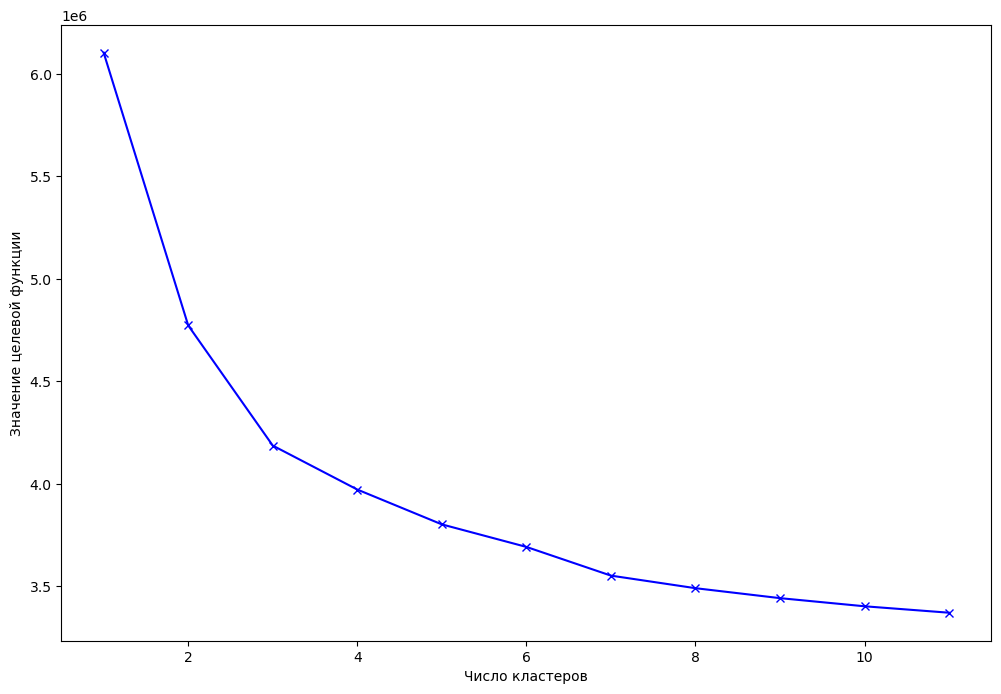

In [ ]:
# plt.figure(figsize=(12, 8))
# plt.plot(K, distortion, 'bx-')
# plt.xlabel('Число кластеров')
# plt.ylabel('Значение целевой функции');

In [ ]:
# kmeans = KMeans(n_clusters=7, random_state=12345)
# kmeans.fit(ohe)
# imputed_good_train['kmeans_label'] = kmeans.labels_.astype(int)

In [ ]:
# # plus kmeans cluster
# X = imputed_good_train.drop(['vin', 'seller', 'sellingprice', 'saledate', 'make_model', 'na_sum'], axis=1)
# y = imputed_good_train['sellingprice']

# num_features = ['year', 'condition', 'odometer', 'predicted_price', 'saleyear', 'salemonth', 'age', 'km_per_year', 'model_meanprice', 'kmeans_label']
# cat_features = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# linreg = Pipeline(
#     steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
# )

# good_linreg_score = -cross_val_score(linreg, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
# print(good_linreg_score)

# # 0.5353538696498409

0.5353538696498409


Еще вернем данные о продавцах. Их очень много, но рискнем потерять время, чтобы улучшить метрику

In [ ]:
# # plus seller
# X = imputed_good_train.drop(['vin', 'sellingprice', 'saledate', 'make_model', 'na_sum'], axis=1)
# y = imputed_good_train['sellingprice']

# num_features = ['year', 'condition', 'odometer', 'predicted_price', 'saleyear', 'salemonth', 'age', 'km_per_year', 'model_meanprice', 'kmeans_label']
# cat_features = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# linreg = Pipeline(
#     steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
# )

# good_linreg_score = -cross_val_score(linreg, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
# print(good_linreg_score)

# # 0.5125782228297179

0.5125782228297179


Ок, поработаем пока с этим набором признаков. Из всего, что было добавлено в ходе экспериментов, не сработали только средняя цена по модели и количество экземпляров модели в наборе. В итоге используем:
- цену, предсказанную базовой регрессией
- год продажи
- месяц продажи
- возраст авто
- средний пробег за год
- кластер

По метрике мы спустились с 54% (без доп фичей) до 48% (после добавления всех фичей)

# Model selection

Здесь я хотела бы попробовать другие, более сложные модели, первым делом добавить регрессии регуляризацию. Но для этого необходимо уменьшить количество признаков, кодируемых OHE. Как есть сейчас, лассо регрессия считается дольше 20 минут, не говоря даже о подборе параметров.

Попробуем из категориальных столбцов отбросить все, что встречается менее 5 раз

И мне интересно, можно ли использовать make_model вместо двух отдельных столбцов без потери качества

In [ ]:
# X = imputed_good_train.drop(['vin', 'make', 'model', 'sellingprice', 'saledate', 'na_sum'], axis=1)
# y = imputed_good_train['sellingprice']

# num_features = ['year', 'condition', 'odometer', 'predicted_price', 'saleyear', 'salemonth', 'age', 'km_per_year', 'model_meanprice', 'kmeans_label']
# cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# linreg = Pipeline(
#     steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
# )

# good_linreg_score = -cross_val_score(linreg, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
# print(good_linreg_score)

0.5128946644961837


In [ ]:
# X = imputed_bad_train.drop(['vin', 'make', 'model', 'sellingprice', 'saledate', 'na_sum'], axis=1)
# y = imputed_bad_train['sellingprice']

# num_features = ['year', 'condition', 'odometer', 'predicted_price', 'saleyear', 'salemonth', 'age', 'km_per_year', 'model_meanprice']
# cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# linreg = Pipeline(
#     steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
# )

# bad_linreg_score = -cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_absolute_percentage_error').mean()
# print(bad_linreg_score)

1.230409764701714


In [ ]:
# score = good_linreg_score*49/50 + bad_linreg_score/50
# print(score)

0.5272449665002943


Сократим число категорий в категориальных столбцах

In [ ]:
# def cut_categories(df, col, min_frequency=10):
#     new_df = df.copy()
#     new_df[col] = new_df[col].astype('category')

#     top_cat = new_df[col].value_counts().reset_index()
#     others = top_cat[top_cat['count'] < min_frequency][col].to_list()

#     label = 'other'

#     new_df[col] = new_df[col].cat.add_categories([label])
#     new_df[col] = new_df[col].replace(others, label)

#     return new_df

In [ ]:
# good_features_reduced = imputed_good_train.copy()

# for col in cat_features:
#     good_features_reduced = cut_categories(good_features_reduced, col)

In [ ]:
# for col in cat_features:
#     print(col)
#     print(f'is: {good_features_reduced[col].nunique()}')
#     print(f'was: {imputed_good_train[col].nunique()}')

make_model
is: 655
was: 844
trim
is: 990
was: 1840
body
is: 41
was: 45
transmission
is: 2
was: 2
state
is: 38
was: 38
color
is: 19
was: 19
interior
is: 17
was: 17
seller
is: 3154
was: 12844


In [ ]:
# X = good_features_reduced.drop(['vin', 'make', 'model', 'sellingprice', 'saledate', 'na_sum'], axis=1)
# y = good_features_reduced['sellingprice']

# num_features = ['year', 'condition', 'odometer', 'predicted_price', 'saleyear', 'salemonth', 'age', 'km_per_year','model_meanprice', 'kmeans_label']
# cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# linreg = Pipeline(
#     steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
# )

# good_linreg_score = -cross_val_score(linreg, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
# print(good_linreg_score)

0.5074441045940644


Время обработки сократилось порядка 40%, метрика ухудшилась на полпроцента

In [ ]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# lasso = Pipeline(
#     steps=[("preprocessor", preprocessor), ("regressor", Lasso(alpha=0.1))]
# )

# good_lasso_score = -cross_val_score(lasso, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
# print(good_lasso_score)

In [ ]:
# param_grid = {
#     'regressor__alpha': [0.1, 0.5, 1, 10, 30, 50, 100, 200]
#     }

# lasso_grid = GridSearchCV(lasso, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=3)
# lasso_grid.fit(X, y)
# lasso_grid.best_params_

In [ ]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_features),
#         ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
#     ]
# )

# forest = Pipeline(
#     steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor(random_state=12345))]
# )

# good_forest_score = -cross_val_score(forest, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
# print(good_forest_score)

In [ ]:
# X = imputed_good_train[num_features]
# forest = RandomForestRegressor(random_state=12345)

# good_forest_score = -cross_val_score(forest, X, y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
# print(good_forest_score)

Из-за огромного количества категорий, создаваемых при кодировании, все модели, кроме линейной регрессии, обучаются бесконечно долго. Я ждала лассо полтора часа и не дождалась. Сокращение категорий не дало результата - их все равно много, а ошибка при этом растет

Пусть это незрело, но я сразу возьму бустинг. Он быстрый и умеет работать с кучей признаков. Попробую свой обработанный датасет и оригинальный - насколько я помню, и Катбуст, и ЛГБМ делают всю обработку сами и не нуждаются ни в кодировании, ни в предварительном заполнении пропусков.

In [ ]:
# X = good_features_reduced.drop(['vin', 'make', 'model', 'sellingprice', 'saledate', 'na_sum'], axis=1)
# y = good_features_reduced['sellingprice']

# cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']
# cat_idx = [X.columns.get_loc(col) for col in cat_features]

# for col in cat_features:
#     X[col] = pd.Categorical(X[col])

# X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=26)
# eval_set = [(X_eval, y_eval)]

# lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
# lgbm_reg.fit(
#     X_train, 
#     y_train,
#     categorical_feature=cat_idx,
#     eval_set=eval_set,
#     early_stopping_rounds=200,
#     verbose=100
# )

# preds = lgbm_reg.predict(X_eval)
# mape_good = mean_absolute_percentage_error(y_eval, preds)
# print(mape_good)

# # 0.13221342312046294

[100]	valid_0's l2: 3.60455e+06
[200]	valid_0's l2: 3.22054e+06
[300]	valid_0's l2: 3.05128e+06
[400]	valid_0's l2: 2.96384e+06
[500]	valid_0's l2: 2.90616e+06
[600]	valid_0's l2: 2.87453e+06
[700]	valid_0's l2: 2.84295e+06
[800]	valid_0's l2: 2.81874e+06
[900]	valid_0's l2: 2.80334e+06
[1000]	valid_0's l2: 2.79255e+06
[1100]	valid_0's l2: 2.78276e+06
[1200]	valid_0's l2: 2.77728e+06
[1300]	valid_0's l2: 2.76955e+06
[1400]	valid_0's l2: 2.76102e+06
[1500]	valid_0's l2: 2.75823e+06
[1600]	valid_0's l2: 2.7544e+06
[1700]	valid_0's l2: 2.75107e+06
[1800]	valid_0's l2: 2.74714e+06
[1900]	valid_0's l2: 2.74587e+06
[2000]	valid_0's l2: 2.74397e+06
[2100]	valid_0's l2: 2.74101e+06
[2200]	valid_0's l2: 2.73709e+06
[2300]	valid_0's l2: 2.73502e+06
[2400]	valid_0's l2: 2.73461e+06
[2500]	valid_0's l2: 2.73197e+06
[2600]	valid_0's l2: 2.73005e+06
[2700]	valid_0's l2: 2.72926e+06
[2800]	valid_0's l2: 2.72893e+06
[2900]	valid_0's l2: 2.72612e+06
[3000]	valid_0's l2: 2.72601e+06
[3100]	valid_0's l2:

In [ ]:
# X = imputed_bad_train.drop(['vin', 'make', 'model', 'sellingprice', 'saledate', 'na_sum'], axis=1)
# y = imputed_bad_train['sellingprice']

# cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']
# cat_idx = [X.columns.get_loc(col) for col in cat_features]

# for col in cat_features:
#     X[col] = pd.Categorical(X[col])

# X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=26)
# eval_set = [(X_eval, y_eval)]

# lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
# lgbm_reg.fit(
#     X_train, 
#     y_train,
#     categorical_feature=cat_idx,
#     eval_set=eval_set,
#     early_stopping_rounds=200,
#     verbose=100
# )

# preds = lgbm_reg.predict(X_eval)
# mape_bad = mean_absolute_percentage_error(y_eval, preds)
# print(mape_bad)

[100]	valid_0's l2: 2.30712e+07
[200]	valid_0's l2: 2.26551e+07
[300]	valid_0's l2: 2.27366e+07
[400]	valid_0's l2: 2.2793e+07
0.6748863662321773


In [ ]:
# score = mape_good*49/50 + mape_bad/50
# print(score)

0.14306688198269724


Результат существенно лучше. Попробуем для большей части взять несокращенный датасет

In [ ]:
# X = imputed_good_train.drop(['vin', 'make', 'model', 'sellingprice', 'saledate', 'na_sum'], axis=1)
# y = imputed_good_train['sellingprice']

# cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']
# cat_idx = [X.columns.get_loc(col) for col in cat_features]

# for col in cat_features:
#     X[col] = pd.Categorical(X[col])

# X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=26)
# eval_set = [(X_eval, y_eval)]

# lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
# lgbm_reg.fit(
#     X_train, 
#     y_train,
#     categorical_feature=cat_idx,
#     eval_set=eval_set,
#     early_stopping_rounds=200,
#     verbose=100
# )

# preds = lgbm_reg.predict(X_eval)
# mape_good = mean_absolute_percentage_error(y_eval, preds)
# print(mape_good)

# # 0.13163353812789055

[100]	valid_0's l2: 3.53353e+06
[200]	valid_0's l2: 3.1409e+06
[300]	valid_0's l2: 2.97076e+06
[400]	valid_0's l2: 2.87779e+06
[500]	valid_0's l2: 2.814e+06
[600]	valid_0's l2: 2.77453e+06
[700]	valid_0's l2: 2.75137e+06
[800]	valid_0's l2: 2.72797e+06
[900]	valid_0's l2: 2.71141e+06
[1000]	valid_0's l2: 2.70147e+06
[1100]	valid_0's l2: 2.69166e+06
[1200]	valid_0's l2: 2.6844e+06
[1300]	valid_0's l2: 2.67899e+06
[1400]	valid_0's l2: 2.67386e+06
[1500]	valid_0's l2: 2.67114e+06
[1600]	valid_0's l2: 2.66774e+06
[1700]	valid_0's l2: 2.66326e+06
[1800]	valid_0's l2: 2.66106e+06
[1900]	valid_0's l2: 2.656e+06
[2000]	valid_0's l2: 2.65353e+06
[2100]	valid_0's l2: 2.64962e+06
[2200]	valid_0's l2: 2.64813e+06
[2300]	valid_0's l2: 2.6458e+06
[2400]	valid_0's l2: 2.64363e+06
[2500]	valid_0's l2: 2.64403e+06
[2600]	valid_0's l2: 2.6426e+06
[2700]	valid_0's l2: 2.64172e+06
[2800]	valid_0's l2: 2.64138e+06
[2900]	valid_0's l2: 2.64063e+06
[3000]	valid_0's l2: 2.64048e+06
[3100]	valid_0's l2: 2.6393

На доли процента лучше, не будем сокращать. А может быть, вообще не нужно разделять датасет на две модели? Попробуем взять полный. Сначала оригинальный, потом с заполненными пропусками и добавленными признаками

In [ ]:
X = train.drop(['vin', 'make', 'model', 'sellingprice', 'saledate', 'na_sum'], axis=1)
y = train['sellingprice']

cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']
cat_idx = [X.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X[col] = pd.Categorical(X[col])

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=26)
eval_set = [(X_eval, y_eval)]

lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
lgbm_reg.fit(
    X_train, 
    y_train,
    categorical_feature=cat_idx,
    eval_set=eval_set,
    early_stopping_rounds=200,
    verbose=100
)

preds = lgbm_reg.predict(X_eval)
mape_good = mean_absolute_percentage_error(y_eval, preds)
print(mape_good)

# 0.1940814673137792

[100]	valid_0's l2: 6.3585e+06
[200]	valid_0's l2: 5.62296e+06
[300]	valid_0's l2: 5.27294e+06
[400]	valid_0's l2: 5.08046e+06
[500]	valid_0's l2: 4.95035e+06
[600]	valid_0's l2: 4.86327e+06
[700]	valid_0's l2: 4.81547e+06
[800]	valid_0's l2: 4.77812e+06
[900]	valid_0's l2: 4.7439e+06
[1000]	valid_0's l2: 4.71652e+06
[1100]	valid_0's l2: 4.70212e+06
[1200]	valid_0's l2: 4.68127e+06
[1300]	valid_0's l2: 4.6437e+06
[1400]	valid_0's l2: 4.62642e+06
[1500]	valid_0's l2: 4.6182e+06
[1600]	valid_0's l2: 4.60311e+06
[1700]	valid_0's l2: 4.57987e+06
[1800]	valid_0's l2: 4.57473e+06
[1900]	valid_0's l2: 4.56353e+06
[2000]	valid_0's l2: 4.55269e+06
[2100]	valid_0's l2: 4.53605e+06
[2200]	valid_0's l2: 4.53245e+06
[2300]	valid_0's l2: 4.53285e+06
[2400]	valid_0's l2: 4.52542e+06
[2500]	valid_0's l2: 4.52317e+06
[2600]	valid_0's l2: 4.51995e+06
[2700]	valid_0's l2: 4.49794e+06
[2800]	valid_0's l2: 4.49651e+06
[2900]	valid_0's l2: 4.49444e+06
[3000]	valid_0's l2: 4.49367e+06
[3100]	valid_0's l2: 4.

In [ ]:
train['make_model'] = train['make'] + ' ' + train['model']

# add saleyear, salemonth, age, km_per_year
X = train.drop(['vin', 'make', 'model', 'sellingprice', 'saledate', 'predicted_price'], axis=1)
y = train['sellingprice']

cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']
cat_idx = [X.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X[col] = pd.Categorical(X[col])

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=26)
eval_set = [(X_eval, y_eval)]

lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
lgbm_reg.fit(
    X_train, 
    y_train,
    categorical_feature=cat_idx,
    eval_set=eval_set,
    early_stopping_rounds=200,
    verbose=100
)

preds = lgbm_reg.predict(X_eval)
mape_good = mean_absolute_percentage_error(y_eval, preds)
print(mape_good)

[100]	valid_0's l2: 6.28417e+06
[200]	valid_0's l2: 5.52281e+06
[300]	valid_0's l2: 5.16387e+06
[400]	valid_0's l2: 5.00636e+06
[500]	valid_0's l2: 4.88809e+06
[600]	valid_0's l2: 4.80039e+06
[700]	valid_0's l2: 4.7314e+06
[800]	valid_0's l2: 4.69471e+06
[900]	valid_0's l2: 4.65828e+06
[1000]	valid_0's l2: 4.62361e+06
[1100]	valid_0's l2: 4.60681e+06
[1200]	valid_0's l2: 4.5882e+06
[1300]	valid_0's l2: 4.5731e+06
[1400]	valid_0's l2: 4.55878e+06
[1500]	valid_0's l2: 4.54577e+06
[1600]	valid_0's l2: 4.5394e+06
[1700]	valid_0's l2: 4.52218e+06
[1800]	valid_0's l2: 4.51269e+06
[1900]	valid_0's l2: 4.50292e+06
[2000]	valid_0's l2: 4.49943e+06
[2100]	valid_0's l2: 4.49204e+06
[2200]	valid_0's l2: 4.49055e+06
[2300]	valid_0's l2: 4.48833e+06
[2400]	valid_0's l2: 4.48653e+06
[2500]	valid_0's l2: 4.48641e+06
[2600]	valid_0's l2: 4.48697e+06
0.19759904633862857


Делаем вывод, что предобработка все же нужна. Результат на сыром датасете хуже

In [ ]:
# imputed_bad_train['kmeans_label'] = 7       # присвоим всем строкам из "плохого" датасета кластер 7

# recombined_train = pd.concat([imputed_good_train, imputed_bad_train])
# recombined_train.shape

(440236, 24)

In [ ]:
# X = recombined_train.drop(['vin', 'make', 'model', 'sellingprice', 'saledate', 'na_sum'], axis=1)
# y = recombined_train['sellingprice']

# cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']
# cat_idx = [X.columns.get_loc(col) for col in cat_features]

# for col in cat_features:
#     X[col] = pd.Categorical(X[col])

# X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=26)
# eval_set = [(X_eval, y_eval)]

# lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
# lgbm_reg.fit(
#     X_train, 
#     y_train,
#     categorical_feature=cat_idx,
#     eval_set=eval_set,
#     early_stopping_rounds=200,
#     verbose=100
# )

# preds = lgbm_reg.predict(X_eval)
# mape_good = mean_absolute_percentage_error(y_eval, preds)
# print(mape_good)

# # 0.14244878419236845

[100]	valid_0's l2: 3.85842e+06
[200]	valid_0's l2: 3.47488e+06
[300]	valid_0's l2: 3.30323e+06
[400]	valid_0's l2: 3.21696e+06
[500]	valid_0's l2: 3.16451e+06
[600]	valid_0's l2: 3.12703e+06
[700]	valid_0's l2: 3.09754e+06
[800]	valid_0's l2: 3.07138e+06
[900]	valid_0's l2: 3.05287e+06
[1000]	valid_0's l2: 3.03807e+06
[1100]	valid_0's l2: 3.02393e+06
[1200]	valid_0's l2: 3.0145e+06
[1300]	valid_0's l2: 3.00911e+06
[1400]	valid_0's l2: 3.0029e+06
[1500]	valid_0's l2: 2.99662e+06
[1600]	valid_0's l2: 2.99485e+06
[1700]	valid_0's l2: 2.99238e+06
[1800]	valid_0's l2: 2.99083e+06
[1900]	valid_0's l2: 2.98919e+06
[2000]	valid_0's l2: 2.98786e+06
[2100]	valid_0's l2: 2.98489e+06
[2200]	valid_0's l2: 2.98341e+06
[2300]	valid_0's l2: 2.9804e+06
[2400]	valid_0's l2: 2.97782e+06
[2500]	valid_0's l2: 2.97548e+06
[2600]	valid_0's l2: 2.97516e+06
[2700]	valid_0's l2: 2.97477e+06
[2800]	valid_0's l2: 2.97476e+06
[2900]	valid_0's l2: 2.97393e+06
[3000]	valid_0's l2: 2.9721e+06
[3100]	valid_0's l2: 2.

Делаем вывод, что разделение на две модели нецелесообразно. Сливаем все обратно в единый датасет, ЛГБМ сам разберется

In [ ]:
# lgbm_reg.feature_importances_

array([ 3123,  9914,  1423,   187,  5015,  5829, 10044,  2434,   858,
       16036, 10039, 10184,   206,  3481,  1492, 10161,  7760,  3184])

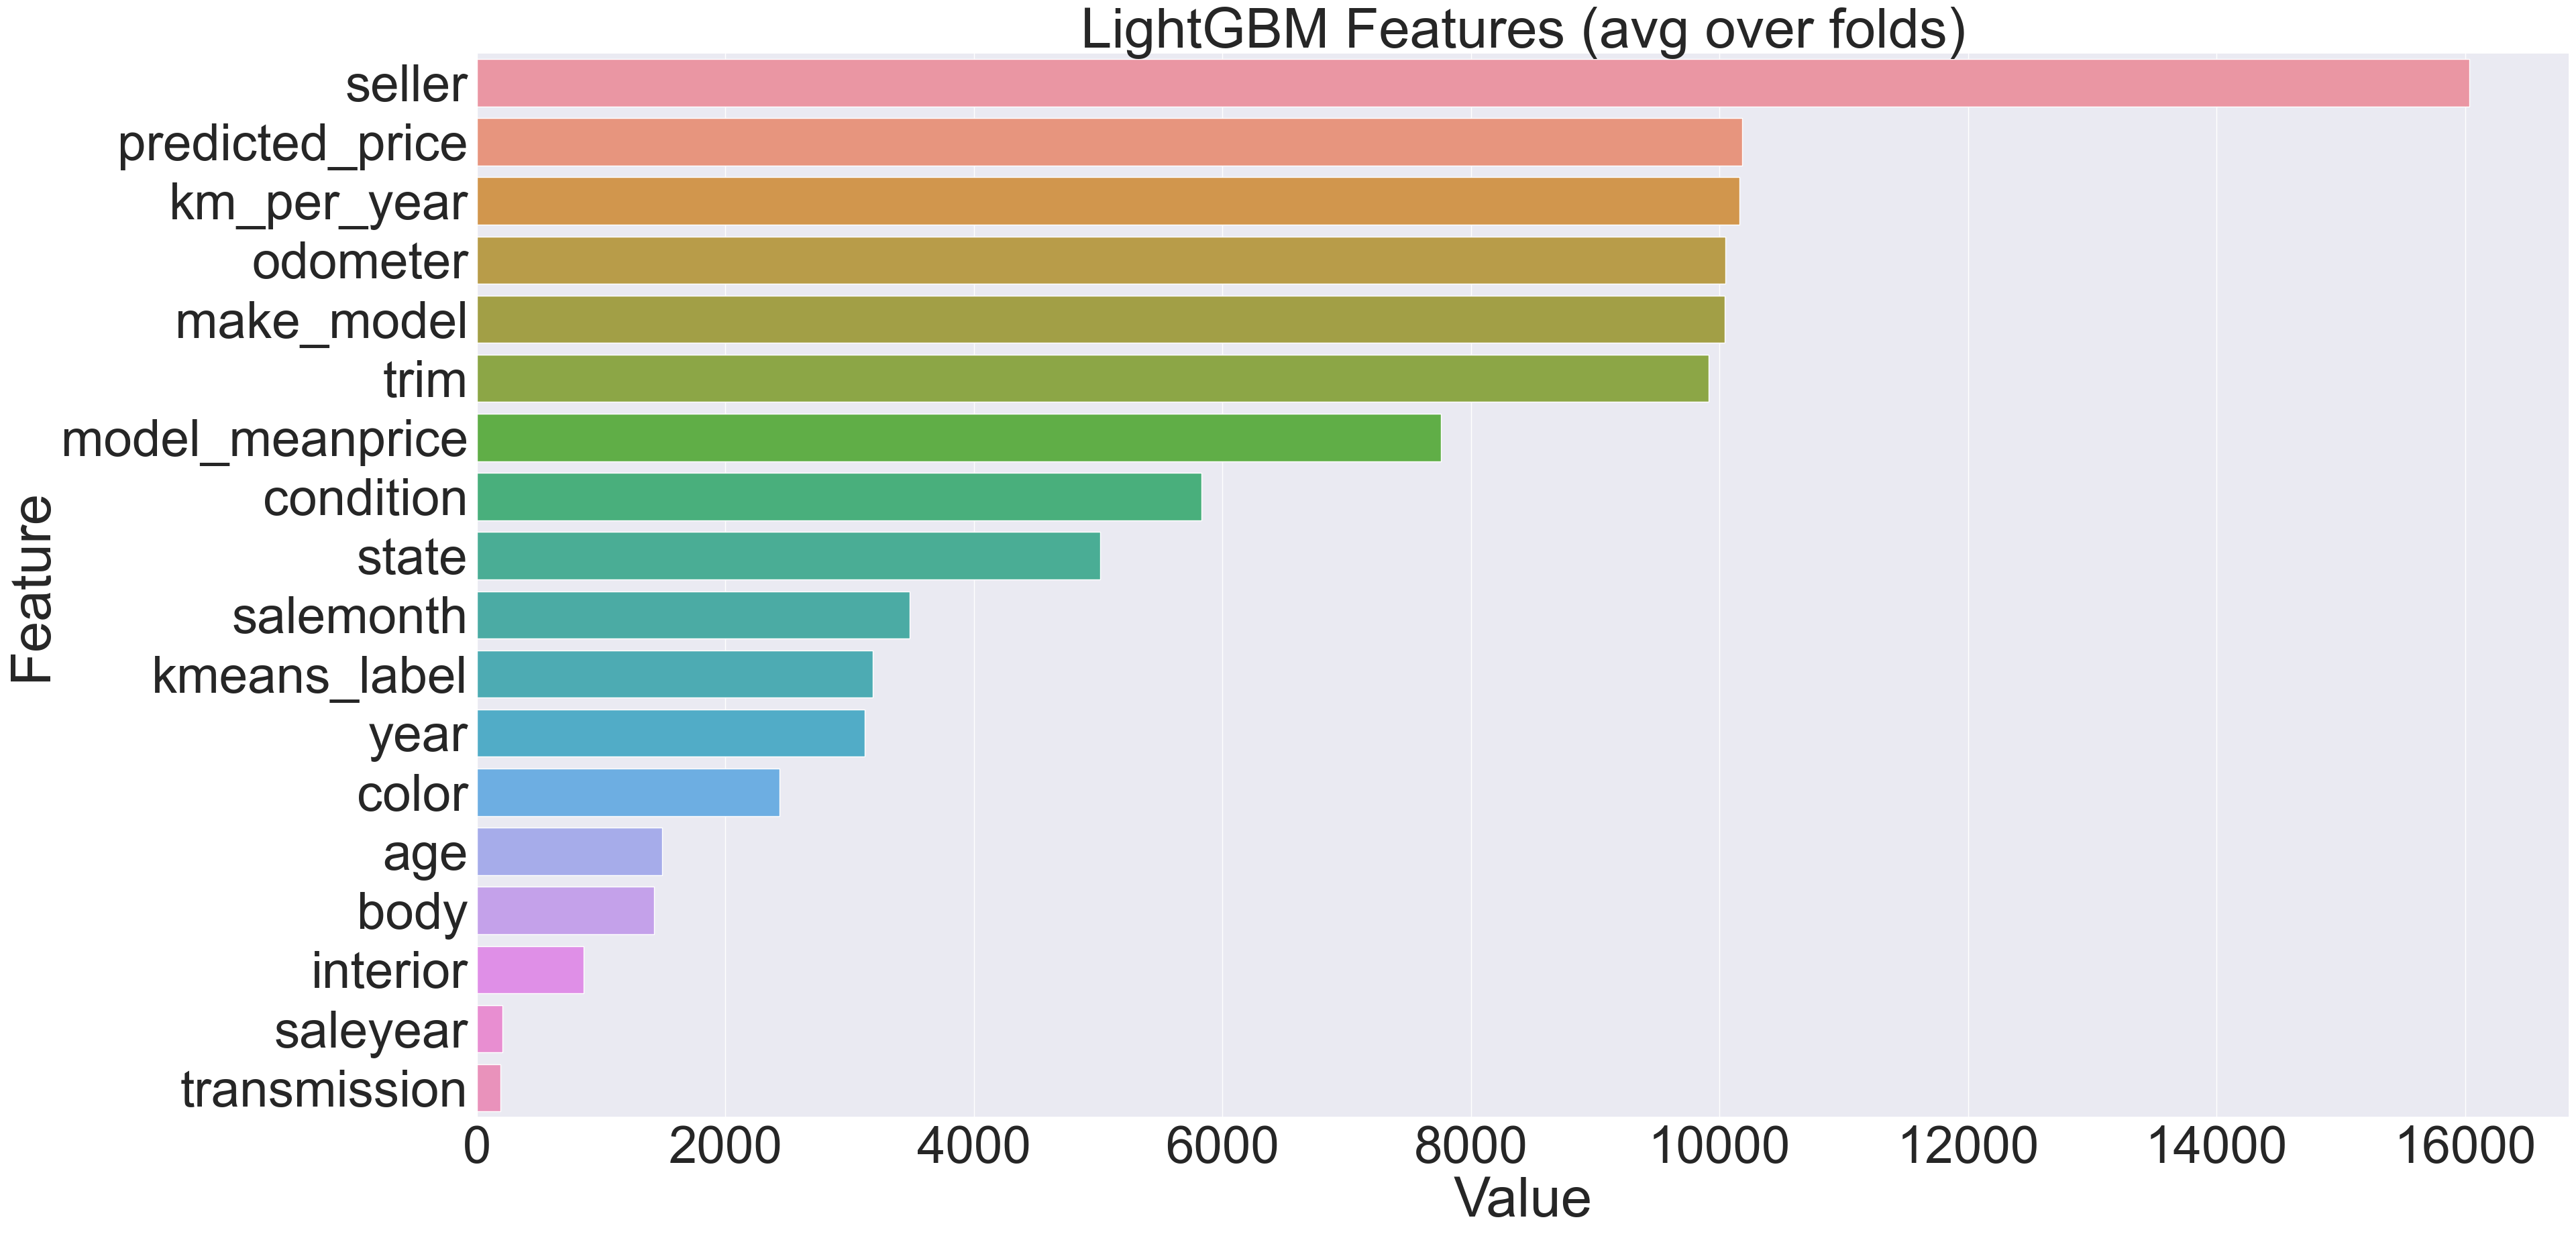

In [ ]:
# def plotImp(model, X , num = 20, fig_size = (40, 20)):
#     feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
#     plt.figure(figsize=fig_size)
#     sns.set(font_scale = 5)
#     sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
#                                                         ascending=False)[0:num])
#     plt.title('LightGBM Features (avg over folds)')
#     plt.tight_layout()
#     plt.savefig('lgbm_importances-01.png')
#     plt.show()

# plotImp(lgbm_reg, X)

У этой модели на тесте высокая ошибка. Интересно, какой большой вес имеет продавец - мне кажется, это не особенно важный признак. Посмотрим, что будет, если обучиться без продавцов

[100]	valid_0's l2: 3.9972e+06
[200]	valid_0's l2: 3.58859e+06
[300]	valid_0's l2: 3.39992e+06
[400]	valid_0's l2: 3.31164e+06
[500]	valid_0's l2: 3.26436e+06
[600]	valid_0's l2: 3.22244e+06
[700]	valid_0's l2: 3.19415e+06
[800]	valid_0's l2: 3.1752e+06
[900]	valid_0's l2: 3.16122e+06
[1000]	valid_0's l2: 3.15161e+06
[1100]	valid_0's l2: 3.14089e+06
[1200]	valid_0's l2: 3.13139e+06
[1300]	valid_0's l2: 3.12366e+06
[1400]	valid_0's l2: 3.11748e+06
[1500]	valid_0's l2: 3.10944e+06
[1600]	valid_0's l2: 3.10665e+06
[1700]	valid_0's l2: 3.10271e+06
[1800]	valid_0's l2: 3.1011e+06
[1900]	valid_0's l2: 3.0986e+06
[2000]	valid_0's l2: 3.09868e+06
0.1470513900046155


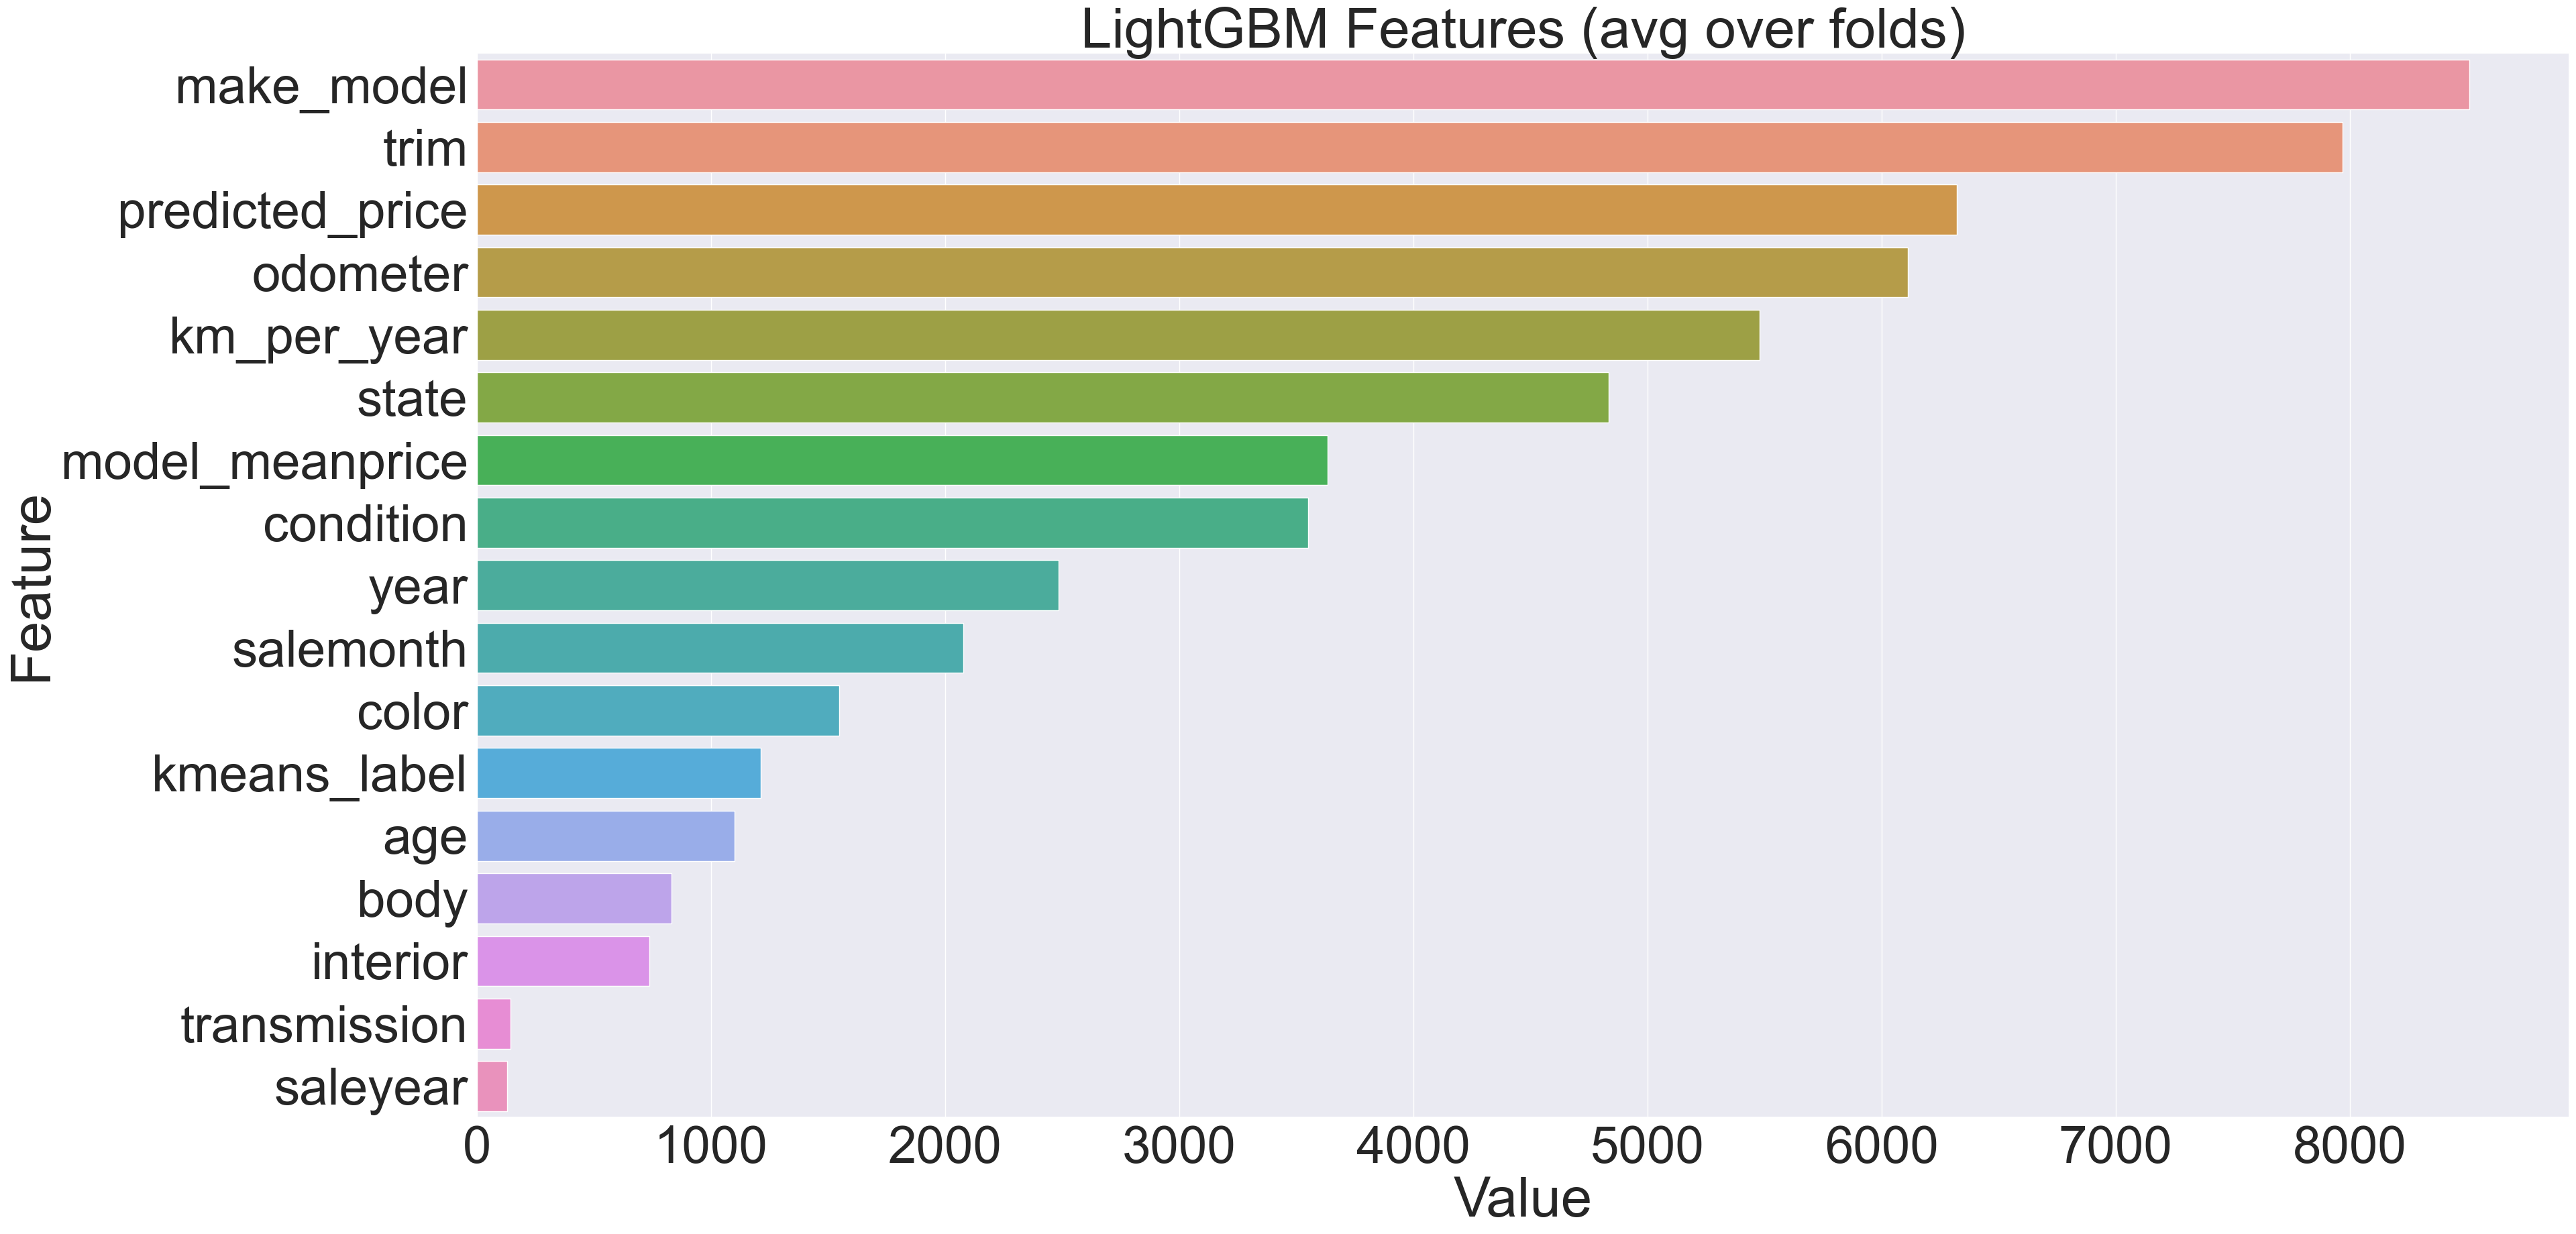

In [ ]:
X = recombined_train.drop(['vin', 'make', 'model', 'sellingprice', 'saledate', 'na_sum', 'seller'], axis=1)
y = recombined_train['sellingprice']

cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']
cat_idx = [X.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X[col] = pd.Categorical(X[col])

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=26)
eval_set = [(X_eval, y_eval)]

lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
lgbm_reg.fit(
    X_train, 
    y_train,
    categorical_feature=cat_idx,
    eval_set=eval_set,
    early_stopping_rounds=200,
    verbose=100
)

preds = lgbm_reg.predict(X_eval)
mape_good = mean_absolute_percentage_error(y_eval, preds)
print(mape_good)
plotImp(lgbm_reg, X)

Mape на тесте = 40, стало хуже. Хотя на уровне здравого смысла мне кажется нормальным, что главный признак - это марка-модель

Попробуем Катбуст.

upd не лучший вариант, считается полчаса и mape 45

In [ ]:
X = recombined_train.drop(['vin', 'make', 'model', 'sellingprice', 'saledate', 'na_sum', 'predicted_price', 'kmeans_label'], axis=1)
y = recombined_train['sellingprice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=26)

from catboost import CatBoostRegressor

cat = CatBoostRegressor(iterations=10000, 
                           loss_function='MAPE',
                           learning_rate=0.1, 
                           cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller'],
                           devices='0:1', early_stopping_rounds=100)
cat.fit(X_train,
          y_train,          
          eval_set=(X_valid, y_valid),    
          cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller'],
          early_stopping_rounds=100,
          verbose=100)


preds = cat.predict(X_eval)
print(mean_absolute_percentage_error(y_eval, preds))

0:	learn: 0.8298677	test: 0.8173162	best: 0.8173162 (0)	total: 350ms	remaining: 58m 17s
100:	learn: 0.5413806	test: 0.5386102	best: 0.5386102 (100)	total: 30.1s	remaining: 49m 11s
200:	learn: 0.5249059	test: 0.5235385	best: 0.5235385 (200)	total: 57.8s	remaining: 46m 56s
300:	learn: 0.5220931	test: 0.5212011	best: 0.5212011 (300)	total: 1m 22s	remaining: 44m 16s
400:	learn: 0.5195075	test: 0.5188166	best: 0.5188162 (398)	total: 1m 45s	remaining: 42m 14s
500:	learn: 0.5155300	test: 0.5148797	best: 0.5148794 (499)	total: 2m 9s	remaining: 40m 54s
600:	learn: 0.5142065	test: 0.5135790	best: 0.5135789 (598)	total: 2m 31s	remaining: 39m 33s
700:	learn: 0.5127372	test: 0.5121534	best: 0.5121534 (700)	total: 2m 53s	remaining: 38m 20s
800:	learn: 0.5101833	test: 0.5095742	best: 0.5095742 (800)	total: 3m 14s	remaining: 37m 18s
900:	learn: 0.5080985	test: 0.5074867	best: 0.5074867 (866)	total: 3m 30s	remaining: 35m 30s
1000:	learn: 0.5067371	test: 0.5061237	best: 0.5061237 (1000)	total: 3m 46s	re

Лучший результат дает LightGBM на сыром датасете, без обработки. Применим Оптуну и посмотрим, можно ли что-то улучшить (обычно нет)

In [ ]:
# add saleyear, salemonth, age, km_per_year
# add model meanprice
X = train.drop(['vin', 'make', 'model', 'sellingprice', 'saledate', 'predicted_price'], axis=1)
y = train['sellingprice']

cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']
cat_idx = [X.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X[col] = pd.Categorical(X[col])

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=26)
eval_set = [(X_eval, y_eval)]

lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
lgbm_reg.fit(
    X_train, 
    y_train,
    categorical_feature=cat_idx,
    eval_set=eval_set,
    early_stopping_rounds=200,
    verbose=100
)

preds = lgbm_reg.predict(X_eval)
mape_good = mean_absolute_percentage_error(y_eval, preds)
print(mape_good)

[100]	valid_0's l2: 3.94291e+06
[200]	valid_0's l2: 3.4989e+06
[300]	valid_0's l2: 3.32569e+06
[400]	valid_0's l2: 3.23656e+06
[500]	valid_0's l2: 3.18451e+06
[600]	valid_0's l2: 3.1497e+06
[700]	valid_0's l2: 3.12481e+06
[800]	valid_0's l2: 3.10198e+06
[900]	valid_0's l2: 3.08619e+06
[1000]	valid_0's l2: 3.07e+06
[1100]	valid_0's l2: 3.05954e+06
[1200]	valid_0's l2: 3.05116e+06
[1300]	valid_0's l2: 3.04199e+06
[1400]	valid_0's l2: 3.03535e+06
[1500]	valid_0's l2: 3.03039e+06
[1600]	valid_0's l2: 3.02709e+06
[1700]	valid_0's l2: 3.02154e+06
[1800]	valid_0's l2: 3.01865e+06
[1900]	valid_0's l2: 3.01449e+06
[2000]	valid_0's l2: 3.0092e+06
[2100]	valid_0's l2: 3.00662e+06
[2200]	valid_0's l2: 3.00271e+06
[2300]	valid_0's l2: 3.00252e+06
[2400]	valid_0's l2: 3.00074e+06
[2500]	valid_0's l2: 2.99804e+06
[2600]	valid_0's l2: 2.99499e+06
[2700]	valid_0's l2: 2.99464e+06
[2800]	valid_0's l2: 2.99412e+06
[2900]	valid_0's l2: 2.99105e+06
[3000]	valid_0's l2: 2.99149e+06
[3100]	valid_0's l2: 2.99

In [ ]:
def objective(trial, data=X, target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=26)
    param = {
        'metric': 'mae', 
        'random_state': 26,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=500)
    
    preds = model.predict(test_x)
    
    mape = mean_absolute_percentage_error(test_y, preds)

    trial.set_user_attr(key="best_booster", value=model)
    
    return mape

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='minimize'
    )
    study.optimize(objective, n_trials=15, callbacks=[callback])
    best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-08-26 14:19:48,670] A new study created in memory with name: no-name-e348fb28-1fc8-4197-9d1a-c3298186c483


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.5
[500]	valid_0's l1: 1146.69
[1000]	valid_0's l1: 1100.54
[1500]	valid_0's l1: 1073.36
[2000]	valid_0's l1: 1058.49
[2500]	valid_0's l1: 1046.15
[3000]	valid_0's l1: 1038.4
[3500]	valid_0's l1: 1032.25
[4000]	valid_0's l1: 1027.72
[4500]	valid_0's l1: 1023.45
[5000]	valid_0's l1: 1019.23
[5500]	valid_0's l1: 1015.87
[6000]	valid_0's l1: 1012.88
[6500]	valid_0's l1: 1009.81
[7000]	valid_0's l1: 1006.97
[7500]	valid_0's l1: 1004.75
[8000]	valid_0's l1: 1002.84
[8500]	valid_0's l1: 1001.53
[9000]	valid_0's l1: 999.758
[9500]	valid_0's l1: 998.121
[10000]	valid_0's l1: 996.837
[10500]	valid_0's l1: 995.873
[11000]	valid_0's l1: 995.007
[11500]	valid_0's l1: 994.384
[12000]	valid_0's l1: 993.635
[12500]	valid_0's l1: 992.978
[13000]	valid_0's l1: 992.064
[13500]	valid_0's l1: 991.377
[14000]	valid_0's l1: 990.635
[14500]	valid_0's l1: 990.149
[15000]	valid_0's l1: 989.6

[I 2023-08-26 14:25:54,429] Trial 0 finished with value: 0.16409847628267887 and parameters: {'reg_alpha': 0.33212113980420516, 'reg_lambda': 7.752862329116004, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 102, 'min_child_samples': 286, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.16409847628267887.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.4
[500]	valid_0's l1: 1063.93
[1000]	valid_0's l1: 1012.77
[1500]	valid_0's l1: 1002.02
[2000]	valid_0's l1: 998.943


[I 2023-08-26 14:31:19,798] Trial 1 finished with value: 0.15059449638094016 and parameters: {'reg_alpha': 2.397510134045005, 'reg_lambda': 0.002253923251590168, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 903, 'min_child_samples': 262, 'feature_fraction': 0.4}. Best is trial 1 with value: 0.15059449638094016.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[500]	valid_0's l1: 1580.13
[1000]	valid_0's l1: 1249.72
[1500]	valid_0's l1: 1181.32
[2000]	valid_0's l1: 1146.91
[2500]	valid_0's l1: 1124.5
[3000]	valid_0's l1: 1107.58
[3500]	valid_0's l1: 1094.78
[4000]	valid_0's l1: 1084.71
[4500]	valid_0's l1: 1076.92
[5000]	valid_0's l1: 1070.52
[5500]	valid_0's l1: 1064.94
[6000]	valid_0's l1: 1059.32
[6500]	valid_0's l1: 1054.65
[7000]	valid_0's l1: 1050.58
[7500]	valid_0's l1: 1046.79
[8000]	valid_0's l1: 1043.08
[8500]	valid_0's l1: 1039.71
[9000]	valid_0's l1: 1036.87
[9500]	valid_0's l1: 1034.24
[10000]	valid_0's l1: 1031.85
[10500]	valid_0's l1: 1029.82
[11000]	valid_0's l1: 1027.94
[11500]	valid_0's l1: 1026.39
[12000]	valid_0's l1: 1025.17
[12500]	valid_0's l1: 1023.58
[13000]	valid_0's l1: 1022.49
[13500]	valid_0's l1: 1021.49
[14000]	valid_0's l1: 1020.1
[14500]	valid_0's l1: 1019.04
[15000]	valid_0's l1: 1018.1

[I 2023-08-26 14:40:47,042] Trial 2 finished with value: 0.1564974433524858 and parameters: {'reg_alpha': 0.006335964661829641, 'reg_lambda': 0.2285169371286554, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 459, 'min_child_samples': 185, 'feature_fraction': 0.4}. Best is trial 1 with value: 0.15059449638094016.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.2
[500]	valid_0's l1: 2142.47
[1000]	valid_0's l1: 1467.15
[1500]	valid_0's l1: 1311.23
[2000]	valid_0's l1: 1236.35
[2500]	valid_0's l1: 1191.2
[3000]	valid_0's l1: 1160.41
[3500]	valid_0's l1: 1137.21
[4000]	valid_0's l1: 1119.83
[4500]	valid_0's l1: 1105.81
[5000]	valid_0's l1: 1094.15
[5500]	valid_0's l1: 1084.02
[6000]	valid_0's l1: 1075.56
[6500]	valid_0's l1: 1068.01
[7000]	valid_0's l1: 1061.26
[7500]	valid_0's l1: 1055.77
[8000]	valid_0's l1: 1050.8
[8500]	valid_0's l1: 1046.84
[9000]	valid_0's l1: 1043.53
[9500]	valid_0's l1: 1040.56
[10000]	valid_0's l1: 1037.8
[10500]	valid_0's l1: 1035.42
[11000]	valid_0's l1: 1033.24
[11500]	valid_0's l1: 1031.39
[12000]	valid_0's l1: 1029.5
[12500]	valid_0's l1: 1027.86
[13000]	valid_0's l1: 1026.47
[13500]	valid_0's l1: 1025.25
[14000]	valid_0's l1: 1024.24
[14500]	valid_0's l1: 1023.14
[15000]	valid_0's l1: 1022.2
[

[I 2023-08-26 14:56:05,488] Trial 3 finished with value: 0.16766385923199498 and parameters: {'reg_alpha': 0.548356809193631, 'reg_lambda': 0.005090493810938258, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 200, 'min_child_samples': 148, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.15059449638094016.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.6000000000000001
[500]	valid_0's l1: 1017.93
[1000]	valid_0's l1: 984.405
[1500]	valid_0's l1: 974.158
[2000]	valid_0's l1: 970.226
[2500]	valid_0's l1: 967.938
[3000]	valid_0's l1: 966.586
[3500]	valid_0's l1: 965.083
[4000]	valid_0's l1: 964.715


[I 2023-08-26 15:01:06,469] Trial 4 finished with value: 0.15888599313603366 and parameters: {'reg_alpha': 0.13019431083163607, 'reg_lambda': 0.007026868824184832, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 268, 'min_child_samples': 57, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.15059449638094016.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1303.24
[1000]	valid_0's l1: 1131.26
[1500]	valid_0's l1: 1102.7
[2000]	valid_0's l1: 1087.2
[2500]	valid_0's l1: 1077.7
[3000]	valid_0's l1: 1069.58
[3500]	valid_0's l1: 1063.44
[4000]	valid_0's l1: 1058.87
[4500]	valid_0's l1: 1054.05
[5000]	valid_0's l1: 1050.17
[5500]	valid_0's l1: 1046.19
[6000]	valid_0's l1: 1043.34
[6500]	valid_0's l1: 1040.69
[7000]	valid_0's l1: 1037.57
[7500]	valid_0's l1: 1034.22
[8000]	valid_0's l1: 1031.41
[8500]	valid_0's l1: 1029.35
[9000]	valid_0's l1: 1026.93
[9500]	valid_0's l1: 1024.9
[10000]	valid_0's l1: 1023.04
[10500]	valid_0's l1: 1021
[11000]	valid_0's l1: 1019.32
[11500]	valid_0's l1: 1018.08
[12000]	valid_0's l1: 1016.4
[12500]	valid_0's l1: 1014.94
[13000]	valid_0's l1: 1013.62
[13500]	valid_0's l1: 1012.41
[14000]	valid_0's l1: 1011.42
[14500]	valid_0's l1: 1010.5
[15000]	valid_0's l1: 1009.61
[1550

[I 2023-08-26 15:10:07,118] Trial 5 finished with value: 0.14577417268228615 and parameters: {'reg_alpha': 0.5777729738292966, 'reg_lambda': 6.628067975280775, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 290, 'min_child_samples': 224, 'feature_fraction': 0.9}. Best is trial 5 with value: 0.14577417268228615.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1003.02
[1000]	valid_0's l1: 990.923


[I 2023-08-26 15:14:49,262] Trial 6 finished with value: 0.14653922901822194 and parameters: {'reg_alpha': 2.733348955441408, 'reg_lambda': 0.005318623821113565, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 767, 'min_child_samples': 279, 'feature_fraction': 0.9}. Best is trial 5 with value: 0.14577417268228615.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.6000000000000001
[500]	valid_0's l1: 1164.93
[1000]	valid_0's l1: 1064.4
[1500]	valid_0's l1: 1036.64
[2000]	valid_0's l1: 1018.21
[2500]	valid_0's l1: 1004.62
[3000]	valid_0's l1: 994.788
[3500]	valid_0's l1: 986.543
[4000]	valid_0's l1: 980.019
[4500]	valid_0's l1: 974.913
[5000]	valid_0's l1: 971.224
[5500]	valid_0's l1: 968.187
[6000]	valid_0's l1: 965.865
[6500]	valid_0's l1: 963.852
[7000]	valid_0's l1: 961.951
[7500]	valid_0's l1: 960.114
[8000]	valid_0's l1: 958.656
[8500]	valid_0's l1: 957.629
[9000]	valid_0's l1: 956.358
[9500]	valid_0's l1: 955.389
[10000]	valid_0's l1: 954.515
[10500]	valid_0's l1: 953.754
[11000]	valid_0's l1: 953.032
[11500]	valid_0's l1: 952.468
[12000]	valid_0's l1: 951.843
[12500]	valid_0's l1: 951.428
[13000]	valid_0's l1: 951.045
[13500]	valid_0's l1: 950.773
[14000]	valid_0's l1: 950.437
[14500]	valid_0's l1: 950.0

[I 2023-08-26 15:29:49,764] Trial 7 finished with value: 0.160927029087044 and parameters: {'reg_alpha': 0.2687291314976241, 'reg_lambda': 0.00265519855978973, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 680, 'min_child_samples': 3, 'feature_fraction': 0.6000000000000001}. Best is trial 5 with value: 0.14577417268228615.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[500]	valid_0's l1: 1298.83
[1000]	valid_0's l1: 1095.43
[1500]	valid_0's l1: 1055.6
[2000]	valid_0's l1: 1037.7
[2500]	valid_0's l1: 1022.96
[3000]	valid_0's l1: 1011.15
[3500]	valid_0's l1: 1002.13
[4000]	valid_0's l1: 994.491
[4500]	valid_0's l1: 988.148
[5000]	valid_0's l1: 982.56
[5500]	valid_0's l1: 977.872
[6000]	valid_0's l1: 974.372
[6500]	valid_0's l1: 971.506
[7000]	valid_0's l1: 969.051
[7500]	valid_0's l1: 966.974
[8000]	valid_0's l1: 965.334
[8500]	valid_0's l1: 963.704
[9000]	valid_0's l1: 962.179
[9500]	valid_0's l1: 960.834
[10000]	valid_0's l1: 959.468
[10500]	valid_0's l1: 958.342
[11000]	valid_0's l1: 957.301
[11500]	valid_0's l1: 956.454
[12000]	valid_0's l1: 955.63
[12500]	valid_0's l1: 954.829
[13000]	valid_0's l1: 954.131
[13500]	valid_0's l1: 953.444
[14000]	valid_0's l1: 952.828
[14500]	valid_0's l1: 952.373


[I 2023-08-26 15:46:46,699] Trial 8 finished with value: 0.15900820516665035 and parameters: {'reg_alpha': 0.0012729664578189585, 'reg_lambda': 0.04657183207949988, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 466, 'min_child_samples': 3, 'feature_fraction': 0.6000000000000001}. Best is trial 5 with value: 0.14577417268228615.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.2
[500]	valid_0's l1: 2246.61
[1000]	valid_0's l1: 1540.3
[1500]	valid_0's l1: 1387.75
[2000]	valid_0's l1: 1317.12
[2500]	valid_0's l1: 1276.27
[3000]	valid_0's l1: 1247.71
[3500]	valid_0's l1: 1225.68
[4000]	valid_0's l1: 1209.41
[4500]	valid_0's l1: 1195.33
[5000]	valid_0's l1: 1183.2
[5500]	valid_0's l1: 1173.37
[6000]	valid_0's l1: 1164.88
[6500]	valid_0's l1: 1156.95
[7000]	valid_0's l1: 1149.96
[7500]	valid_0's l1: 1143.94
[8000]	valid_0's l1: 1137.87
[8500]	valid_0's l1: 1132.75
[9000]	valid_0's l1: 1128.04
[9500]	valid_0's l1: 1123.74
[10000]	valid_0's l1: 1119.92
[10500]	valid_0's l1: 1116.54
[11000]	valid_0's l1: 1113.48
[11500]	valid_0's l1: 1110.78
[12000]	valid_0's l1: 1108.05
[12500]	valid_0's l1: 1105.21
[13000]	valid_0's l1: 1102.82
[13500]	valid_0's l1: 1100.45
[14000]	valid_0's l1: 1098.56
[14500]	valid_0's l1: 1096.71
[15000]	valid_0's l1: 1094.8

[I 2023-08-26 15:55:27,066] Trial 9 finished with value: 0.18470113072622837 and parameters: {'reg_alpha': 0.002359858070481659, 'reg_lambda': 0.10223802724772121, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 644, 'min_child_samples': 233, 'feature_fraction': 0.2}. Best is trial 5 with value: 0.14577417268228615.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1039.86
[1000]	valid_0's l1: 1016.33
[1500]	valid_0's l1: 1002.46
[2000]	valid_0's l1: 995.059
[2500]	valid_0's l1: 989.877
[3000]	valid_0's l1: 986.251
[3500]	valid_0's l1: 984.067
[4000]	valid_0's l1: 982.247
[4500]	valid_0's l1: 980.801
[5000]	valid_0's l1: 979.679
[5500]	valid_0's l1: 978.558


[I 2023-08-26 16:00:46,537] Trial 10 finished with value: 0.14286235990470778 and parameters: {'reg_alpha': 0.028391004061669868, 'reg_lambda': 7.579567523218998, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 394, 'min_child_samples': 140, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.14286235990470778.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1046.11
[1000]	valid_0's l1: 1020.44
[1500]	valid_0's l1: 1006.16
[2000]	valid_0's l1: 997.885
[2500]	valid_0's l1: 992.323
[3000]	valid_0's l1: 989.089
[3500]	valid_0's l1: 986.462
[4000]	valid_0's l1: 984.929
[4500]	valid_0's l1: 983.425
[5000]	valid_0's l1: 982.501
[5500]	valid_0's l1: 981.788
[6000]	valid_0's l1: 981.28


[I 2023-08-26 16:06:48,011] Trial 11 finished with value: 0.14872830833469944 and parameters: {'reg_alpha': 0.029689622079457773, 'reg_lambda': 4.182260264393777, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 323, 'min_child_samples': 136, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.14286235990470778.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1207.26
[1000]	valid_0's l1: 1126.92
[1500]	valid_0's l1: 1091.87
[2000]	valid_0's l1: 1070.07
[2500]	valid_0's l1: 1056.04
[3000]	valid_0's l1: 1047.25
[3500]	valid_0's l1: 1041.41
[4000]	valid_0's l1: 1035.76
[4500]	valid_0's l1: 1031.74
[5000]	valid_0's l1: 1028.34
[5500]	valid_0's l1: 1025.17
[6000]	valid_0's l1: 1022.69
[6500]	valid_0's l1: 1020.13
[7000]	valid_0's l1: 1018.12
[7500]	valid_0's l1: 1016.27
[8000]	valid_0's l1: 1014.53
[8500]	valid_0's l1: 1012.84
[9000]	valid_0's l1: 1011.05
[9500]	valid_0's l1: 1009.72
[10000]	valid_0's l1: 1008.41
[10500]	valid_0's l1: 1007.09
[11000]	valid_0's l1: 1006.05
[11500]	valid_0's l1: 1005.28
[12000]	valid_0's l1: 1004.21
[12500]	valid_0's l1: 1003.59
[13000]	valid_0's l1: 1002.76
[13500]	valid_0's l1: 1001.91
[14000]	valid_0's l1: 1001.43
[14500]	valid_0's l1: 1001.09
[15000]	valid_0's l1: 1000

[I 2023-08-26 16:13:26,515] Trial 12 finished with value: 0.17223457654509614 and parameters: {'reg_alpha': 0.03665010312347869, 'reg_lambda': 1.769556861016835, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 37, 'min_child_samples': 199, 'feature_fraction': 0.8}. Best is trial 10 with value: 0.14286235990470778.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l1: 1064.46
[1000]	valid_0's l1: 1016.61
[1500]	valid_0's l1: 1001.08
[2000]	valid_0's l1: 990.96
[2500]	valid_0's l1: 984.407
[3000]	valid_0's l1: 979.989
[3500]	valid_0's l1: 976.32
[4000]	valid_0's l1: 973.756
[4500]	valid_0's l1: 971.558
[5000]	valid_0's l1: 970.081
[5500]	valid_0's l1: 968.713
[6000]	valid_0's l1: 967.663
[6500]	valid_0's l1: 967.012
[7000]	valid_0's l1: 966.378
[7500]	valid_0's l1: 965.912
[8000]	valid_0's l1: 965.211
[8500]	valid_0's l1: 964.894
[9000]	valid_0's l1: 964.709


[I 2023-08-26 16:21:35,618] Trial 13 finished with value: 0.1497498649759625 and parameters: {'reg_alpha': 0.05290988323144764, 'reg_lambda': 1.3127590966661542, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 393, 'min_child_samples': 107, 'feature_fraction': 0.7}. Best is trial 10 with value: 0.14286235990470778.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1039.19
[1000]	valid_0's l1: 1016.46
[1500]	valid_0's l1: 1004.72
[2000]	valid_0's l1: 996.935
[2500]	valid_0's l1: 991.613
[3000]	valid_0's l1: 987.13
[3500]	valid_0's l1: 984.353
[4000]	valid_0's l1: 982.203
[4500]	valid_0's l1: 980.208
[5000]	valid_0's l1: 978.985
[5500]	valid_0's l1: 978.203
[6000]	valid_0's l1: 977.443
[6500]	valid_0's l1: 977.036
[7000]	valid_0's l1: 976.581


[I 2023-08-26 16:27:17,210] Trial 14 finished with value: 0.14248923561189014 and parameters: {'reg_alpha': 0.012715395199854897, 'reg_lambda': 9.659511509268365, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 595, 'min_child_samples': 204, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.14248923561189014.


Number of finished trials: 15
Best trial: {'reg_alpha': 0.012715395199854897, 'reg_lambda': 9.659511509268365, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 595, 'min_child_samples': 204, 'feature_fraction': 0.8}


In [ ]:
study.optimize(objective, n_trials=15, callbacks=[callback])
best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1025.65
[1000]	valid_0's l1: 999.681
[1500]	valid_0's l1: 987.964
[2000]	valid_0's l1: 980.879
[2500]	valid_0's l1: 976.725
[3000]	valid_0's l1: 974.061
[3500]	valid_0's l1: 972
[4000]	valid_0's l1: 970.551
[4500]	valid_0's l1: 969.43
[5000]	valid_0's l1: 968.863
[5500]	valid_0's l1: 968.083


[I 2023-08-26 18:42:36,248] Trial 15 finished with value: 0.14084065330709983 and parameters: {'reg_alpha': 0.01253254641565244, 'reg_lambda': 9.89546934400849, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 589, 'min_child_samples': 99, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.14084065330709983.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l1: 1019.46
[1000]	valid_0's l1: 991.524
[1500]	valid_0's l1: 980.442
[2000]	valid_0's l1: 973.464
[2500]	valid_0's l1: 968.688
[3000]	valid_0's l1: 965.694
[3500]	valid_0's l1: 964.086
[4000]	valid_0's l1: 962.248
[4500]	valid_0's l1: 961.073
[5000]	valid_0's l1: 960.414
[5500]	valid_0's l1: 960.159


[I 2023-08-26 18:48:22,098] Trial 16 finished with value: 0.1455806350624412 and parameters: {'reg_alpha': 0.008809302257447141, 'reg_lambda': 1.0349171655553482, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 596, 'min_child_samples': 87, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.14084065330709983.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1009.49
[1000]	valid_0's l1: 987.511
[1500]	valid_0's l1: 977.789
[2000]	valid_0's l1: 973.084
[2500]	valid_0's l1: 969.445
[3000]	valid_0's l1: 967.18
[3500]	valid_0's l1: 965.558


[I 2023-08-26 18:53:06,121] Trial 17 finished with value: 0.14330144669167266 and parameters: {'reg_alpha': 0.009149588893082598, 'reg_lambda': 2.299839785439166, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 824, 'min_child_samples': 57, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.14084065330709983.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1030.03
[1000]	valid_0's l1: 1009.68
[1500]	valid_0's l1: 997.462
[2000]	valid_0's l1: 990.801
[2500]	valid_0's l1: 986.102
[3000]	valid_0's l1: 982.274
[3500]	valid_0's l1: 980.064
[4000]	valid_0's l1: 978.573
[4500]	valid_0's l1: 977.133


[I 2023-08-26 18:57:25,942] Trial 18 finished with value: 0.14015412687209783 and parameters: {'reg_alpha': 0.00285647949387225, 'reg_lambda': 9.799282382869649, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 557, 'min_child_samples': 182, 'feature_fraction': 0.8}. Best is trial 18 with value: 0.14015412687209783.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l1: 1019.74
[1000]	valid_0's l1: 997.38
[1500]	valid_0's l1: 987.748
[2000]	valid_0's l1: 981.606
[2500]	valid_0's l1: 977.644
[3000]	valid_0's l1: 975.161
[3500]	valid_0's l1: 972.737
[4000]	valid_0's l1: 971.373
[4500]	valid_0's l1: 970.42
[5000]	valid_0's l1: 970.059


[I 2023-08-26 19:02:02,843] Trial 19 finished with value: 0.14376006676900877 and parameters: {'reg_alpha': 0.0030796728166231466, 'reg_lambda': 0.5899944064542857, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 957, 'min_child_samples': 173, 'feature_fraction': 0.7}. Best is trial 18 with value: 0.14015412687209783.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1012.54
[1000]	valid_0's l1: 993.646
[1500]	valid_0's l1: 983.377
[2000]	valid_0's l1: 977.867
[2500]	valid_0's l1: 975.095
[3000]	valid_0's l1: 972.904
[3500]	valid_0's l1: 971.899
[4000]	valid_0's l1: 971.09


[I 2023-08-26 19:06:31,325] Trial 20 finished with value: 0.13902716302555834 and parameters: {'reg_alpha': 0.0011186476815715036, 'reg_lambda': 3.1261101959052477, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 748, 'min_child_samples': 113, 'feature_fraction': 0.8}. Best is trial 20 with value: 0.13902716302555834.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1011.94
[1000]	valid_0's l1: 992.754
[1500]	valid_0's l1: 982.753
[2000]	valid_0's l1: 977.415
[2500]	valid_0's l1: 974.92
[3000]	valid_0's l1: 973.29
[3500]	valid_0's l1: 971.964
[4000]	valid_0's l1: 971.111
[4500]	valid_0's l1: 970.316


[I 2023-08-26 19:10:59,086] Trial 21 finished with value: 0.1387886743839587 and parameters: {'reg_alpha': 0.0011190763150779397, 'reg_lambda': 2.90672791655056, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 739, 'min_child_samples': 110, 'feature_fraction': 0.8}. Best is trial 21 with value: 0.1387886743839587.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l1: 1013.88
[1000]	valid_0's l1: 991.662
[1500]	valid_0's l1: 981.378
[2000]	valid_0's l1: 975.101
[2500]	valid_0's l1: 971.069
[3000]	valid_0's l1: 968.128
[3500]	valid_0's l1: 966.771
[4000]	valid_0's l1: 966.079
[4500]	valid_0's l1: 965.289


[I 2023-08-26 19:15:10,720] Trial 22 finished with value: 0.14672537097583419 and parameters: {'reg_alpha': 0.0013005873202201316, 'reg_lambda': 2.5212769376747346, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 756, 'min_child_samples': 126, 'feature_fraction': 0.7}. Best is trial 21 with value: 0.1387886743839587.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1021.45
[1000]	valid_0's l1: 1002.67
[1500]	valid_0's l1: 992.715
[2000]	valid_0's l1: 986.771
[2500]	valid_0's l1: 982.58
[3000]	valid_0's l1: 979.84
[3500]	valid_0's l1: 978.037
[4000]	valid_0's l1: 976.768
[4500]	valid_0's l1: 975.921


[I 2023-08-26 19:19:20,108] Trial 23 finished with value: 0.14085098643733823 and parameters: {'reg_alpha': 0.0010790115509936766, 'reg_lambda': 3.3901345093216015, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 867, 'min_child_samples': 167, 'feature_fraction': 0.8}. Best is trial 21 with value: 0.1387886743839587.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.5
[500]	valid_0's l1: 1015.8
[1000]	valid_0's l1: 984.553
[1500]	valid_0's l1: 973.495
[2000]	valid_0's l1: 967.595
[2500]	valid_0's l1: 964.311
[3000]	valid_0's l1: 962.122
[3500]	valid_0's l1: 960.993
[4000]	valid_0's l1: 960.133
[4500]	valid_0's l1: 959.815


[I 2023-08-26 19:24:32,073] Trial 24 finished with value: 0.14606968704286752 and parameters: {'reg_alpha': 0.0033217050850814257, 'reg_lambda': 0.6292681153590538, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 722, 'min_child_samples': 67, 'feature_fraction': 0.5}. Best is trial 21 with value: 0.1387886743839587.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l1: 991.382
[1000]	valid_0's l1: 967.055
[1500]	valid_0's l1: 962.046
[2000]	valid_0's l1: 959.872
[2500]	valid_0's l1: 959.013


[I 2023-08-26 19:28:55,453] Trial 25 finished with value: 0.1623712972488459 and parameters: {'reg_alpha': 0.0010477526708096339, 'reg_lambda': 3.5831053162200543, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 510, 'min_child_samples': 34, 'feature_fraction': 0.7}. Best is trial 21 with value: 0.1387886743839587.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1013.92
[1000]	valid_0's l1: 995.155
[1500]	valid_0's l1: 984.37
[2000]	valid_0's l1: 979.151
[2500]	valid_0's l1: 976.448
[3000]	valid_0's l1: 974.36
[3500]	valid_0's l1: 972.945
[4000]	valid_0's l1: 972.143


[I 2023-08-26 19:33:11,816] Trial 26 finished with value: 0.1386136450223444 and parameters: {'reg_alpha': 0.004150924034757839, 'reg_lambda': 4.683573611748846, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 808, 'min_child_samples': 119, 'feature_fraction': 0.8}. Best is trial 26 with value: 0.1386136450223444.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1037.15
[1000]	valid_0's l1: 1005.11
[1500]	valid_0's l1: 995.585
[2000]	valid_0's l1: 989.224
[2500]	valid_0's l1: 984.013
[3000]	valid_0's l1: 980.559
[3500]	valid_0's l1: 978.488
[4000]	valid_0's l1: 977.09
[4500]	valid_0's l1: 975.705
[5000]	valid_0's l1: 974.934
[5500]	valid_0's l1: 974.474
[6000]	valid_0's l1: 974.076
[6500]	valid_0's l1: 973.665


[I 2023-08-26 19:40:25,281] Trial 27 finished with value: 0.1463896919863609 and parameters: {'reg_alpha': 0.004466670896595253, 'reg_lambda': 0.7548139769230772, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 973, 'min_child_samples': 116, 'feature_fraction': 0.9}. Best is trial 26 with value: 0.1386136450223444.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l1: 1078.13
[1000]	valid_0's l1: 1007.75
[1500]	valid_0's l1: 992.225
[2000]	valid_0's l1: 983.674
[2500]	valid_0's l1: 978.264
[3000]	valid_0's l1: 974.587
[3500]	valid_0's l1: 971.411
[4000]	valid_0's l1: 968.827
[4500]	valid_0's l1: 966.961
[5000]	valid_0's l1: 965.587
[5500]	valid_0's l1: 964.053
[6000]	valid_0's l1: 962.898
[6500]	valid_0's l1: 962.221
[7000]	valid_0's l1: 961.378
[7500]	valid_0's l1: 960.758
[8000]	valid_0's l1: 960.35


[I 2023-08-26 19:49:18,760] Trial 28 finished with value: 0.15035455698776634 and parameters: {'reg_alpha': 0.0018594693697298824, 'reg_lambda': 1.307336781385366, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 821, 'min_child_samples': 81, 'feature_fraction': 0.7}. Best is trial 26 with value: 0.1386136450223444.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.4
[500]	valid_0's l1: 1071.64
[1000]	valid_0's l1: 1008.48
[1500]	valid_0's l1: 994.496
[2000]	valid_0's l1: 989.445
[2500]	valid_0's l1: 988.111


[I 2023-08-26 19:56:06,611] Trial 29 finished with value: 0.15289438251229165 and parameters: {'reg_alpha': 0.005563560099294126, 'reg_lambda': 4.379537748014493, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 676, 'min_child_samples': 158, 'feature_fraction': 0.4}. Best is trial 26 with value: 0.1386136450223444.


Number of finished trials: 30
Best trial: {'reg_alpha': 0.004150924034757839, 'reg_lambda': 4.683573611748846, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 808, 'min_child_samples': 119, 'feature_fraction': 0.8}


In [ ]:
study.optimize(objective, n_trials=15, callbacks=[callback])
best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5
[500]	valid_0's l1: 1006.91
[1000]	valid_0's l1: 977.25
[1500]	valid_0's l1: 965.326
[2000]	valid_0's l1: 959.39
[2500]	valid_0's l1: 956.446
[3000]	valid_0's l1: 955.085
[3500]	valid_0's l1: 954.477


[I 2023-08-26 20:35:34,792] Trial 30 finished with value: 0.1572279862403251 and parameters: {'reg_alpha': 0.002169875268413784, 'reg_lambda': 1.9845022185408523, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 903, 'min_child_samples': 34, 'feature_fraction': 0.5}. Best is trial 26 with value: 0.1386136450223444.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1022.83
[1000]	valid_0's l1: 1002.18
[1500]	valid_0's l1: 990.069
[2000]	valid_0's l1: 983.985
[2500]	valid_0's l1: 980.605
[3000]	valid_0's l1: 977.631
[3500]	valid_0's l1: 975.598
[4000]	valid_0's l1: 974.648


[I 2023-08-26 20:39:48,593] Trial 31 finished with value: 0.13967718415190292 and parameters: {'reg_alpha': 0.0034953886584079643, 'reg_lambda': 7.039154690765027, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 528, 'min_child_samples': 121, 'feature_fraction': 0.8}. Best is trial 26 with value: 0.1386136450223444.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1013.29
[1000]	valid_0's l1: 994.128
[1500]	valid_0's l1: 983.845
[2000]	valid_0's l1: 978.218
[2500]	valid_0's l1: 975.356
[3000]	valid_0's l1: 973.643
[3500]	valid_0's l1: 972.419
[4000]	valid_0's l1: 971.533


[I 2023-08-26 20:43:44,058] Trial 32 finished with value: 0.1383095227206812 and parameters: {'reg_alpha': 0.0018479364750083936, 'reg_lambda': 4.348503069822695, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 794, 'min_child_samples': 110, 'feature_fraction': 0.8}. Best is trial 32 with value: 0.1383095227206812.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1013.29
[1000]	valid_0's l1: 994.813
[1500]	valid_0's l1: 984.966
[2000]	valid_0's l1: 980.441
[2500]	valid_0's l1: 977.221
[3000]	valid_0's l1: 975.06
[3500]	valid_0's l1: 973.727


[I 2023-08-26 20:47:44,140] Trial 33 finished with value: 0.1400144328978942 and parameters: {'reg_alpha': 0.0017121735849888577, 'reg_lambda': 4.508857137978431, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 780, 'min_child_samples': 98, 'feature_fraction': 0.9}. Best is trial 32 with value: 0.1383095227206812.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[500]	valid_0's l1: 1017.2
[1000]	valid_0's l1: 993.649
[1500]	valid_0's l1: 982.978
[2000]	valid_0's l1: 977.508
[2500]	valid_0's l1: 973.466
[3000]	valid_0's l1: 970.756
[3500]	valid_0's l1: 968.702
[4000]	valid_0's l1: 967.626
[4500]	valid_0's l1: 966.76


[I 2023-08-26 20:52:08,190] Trial 34 finished with value: 0.14846330277913983 and parameters: {'reg_alpha': 0.0010612708310413423, 'reg_lambda': 2.7076167614359723, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 889, 'min_child_samples': 150, 'feature_fraction': 0.6000000000000001}. Best is trial 32 with value: 0.1383095227206812.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.30000000000000004
[500]	valid_0's l1: 1089.68
[1000]	valid_0's l1: 1028.2
[1500]	valid_0's l1: 1003.9
[2000]	valid_0's l1: 991.907
[2500]	valid_0's l1: 986.009
[3000]	valid_0's l1: 983.076
[3500]	valid_0's l1: 980.821
[4000]	valid_0's l1: 979.808


[I 2023-08-26 20:57:03,962] Trial 35 finished with value: 0.14541971841008586 and parameters: {'reg_alpha': 0.004469680056366576, 'reg_lambda': 0.3258684458953388, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 711, 'min_child_samples': 80, 'feature_fraction': 0.30000000000000004}. Best is trial 32 with value: 0.1383095227206812.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 982.896
[1000]	valid_0's l1: 972.728


[I 2023-08-26 21:01:39,827] Trial 36 finished with value: 0.1392204278689772 and parameters: {'reg_alpha': 0.001924340919973062, 'reg_lambda': 5.304428738425867, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 837, 'min_child_samples': 134, 'feature_fraction': 0.8}. Best is trial 32 with value: 0.1383095227206812.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l1: 1179.44
[1000]	valid_0's l1: 1093.49
[1500]	valid_0's l1: 1067.53
[2000]	valid_0's l1: 1050.41
[2500]	valid_0's l1: 1037.47
[3000]	valid_0's l1: 1028.23
[3500]	valid_0's l1: 1020.46
[4000]	valid_0's l1: 1015.28
[4500]	valid_0's l1: 1009.8
[5000]	valid_0's l1: 1006.22
[5500]	valid_0's l1: 1002.81
[6000]	valid_0's l1: 1000.33
[6500]	valid_0's l1: 997.99
[7000]	valid_0's l1: 995.789
[7500]	valid_0's l1: 993.617
[8000]	valid_0's l1: 991.763
[8500]	valid_0's l1: 990.106
[9000]	valid_0's l1: 988.658
[9500]	valid_0's l1: 987.182
[10000]	valid_0's l1: 985.641
[10500]	valid_0's l1: 984.027
[11000]	valid_0's l1: 982.539
[11500]	valid_0's l1: 981.074
[12000]	valid_0's l1: 979.754
[12500]	valid_0's l1: 978.774
[13000]	valid_0's l1: 978.036
[13500]	valid_0's l1: 977.285
[14000]	valid_0's l1: 976.659
[14500]	valid_0's l1: 976.176
[15000]	valid_0's l1: 975.67

[I 2023-08-26 21:12:29,806] Trial 37 finished with value: 0.14630650834751413 and parameters: {'reg_alpha': 0.0065789058296426605, 'reg_lambda': 1.7125817548365276, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 931, 'min_child_samples': 109, 'feature_fraction': 0.7}. Best is trial 32 with value: 0.1383095227206812.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 998.879
[1000]	valid_0's l1: 982.603
[1500]	valid_0's l1: 975.074
[2000]	valid_0's l1: 971.285
[2500]	valid_0's l1: 969.374


[I 2023-08-26 21:16:17,908] Trial 38 finished with value: 0.1391587810662952 and parameters: {'reg_alpha': 0.0018710744132787573, 'reg_lambda': 3.256371022721925, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 991, 'min_child_samples': 51, 'feature_fraction': 0.9}. Best is trial 32 with value: 0.1383095227206812.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.6000000000000001
[500]	valid_0's l1: 983.548
[1000]	valid_0's l1: 962.379
[1500]	valid_0's l1: 959.521


[I 2023-08-26 21:21:22,143] Trial 39 finished with value: 0.15163030362467586 and parameters: {'reg_alpha': 0.005283712028043271, 'reg_lambda': 1.0154244288084766, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 773, 'min_child_samples': 87, 'feature_fraction': 0.6000000000000001}. Best is trial 32 with value: 0.1383095227206812.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1138.95
[1000]	valid_0's l1: 1084.42
[1500]	valid_0's l1: 1063.78
[2000]	valid_0's l1: 1051.27
[2500]	valid_0's l1: 1041.33
[3000]	valid_0's l1: 1034.26
[3500]	valid_0's l1: 1028.39
[4000]	valid_0's l1: 1022.42
[4500]	valid_0's l1: 1017.6
[5000]	valid_0's l1: 1013.64
[5500]	valid_0's l1: 1010.17
[6000]	valid_0's l1: 1007.61
[6500]	valid_0's l1: 1005.03
[7000]	valid_0's l1: 1002.67
[7500]	valid_0's l1: 1000.06
[8000]	valid_0's l1: 998.044
[8500]	valid_0's l1: 996.654
[9000]	valid_0's l1: 995.074
[9500]	valid_0's l1: 993.703
[10000]	valid_0's l1: 992.362
[10500]	valid_0's l1: 991.032
[11000]	valid_0's l1: 989.707
[11500]	valid_0's l1: 988.914
[12000]	valid_0's l1: 987.794
[12500]	valid_0's l1: 986.959
[13000]	valid_0's l1: 986.595


[I 2023-08-26 21:27:26,105] Trial 40 finished with value: 0.1434186579688755 and parameters: {'reg_alpha': 0.003081028285442624, 'reg_lambda': 6.297893369047842, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 644, 'min_child_samples': 148, 'feature_fraction': 0.8}. Best is trial 32 with value: 0.1383095227206812.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 993.251
[1000]	valid_0's l1: 975.076
[1500]	valid_0's l1: 968.275
[2000]	valid_0's l1: 965.285


[I 2023-08-26 21:31:09,142] Trial 41 finished with value: 0.13705067474321944 and parameters: {'reg_alpha': 0.0016698864918656161, 'reg_lambda': 2.998493453750452, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 987, 'min_child_samples': 26, 'feature_fraction': 0.9}. Best is trial 41 with value: 0.13705067474321944.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 995.622
[1000]	valid_0's l1: 976.284
[1500]	valid_0's l1: 969.566
[2000]	valid_0's l1: 966.705


[I 2023-08-26 21:34:33,742] Trial 42 finished with value: 0.13563968149217936 and parameters: {'reg_alpha': 0.0018058171322923393, 'reg_lambda': 2.2486805588618113, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 859, 'min_child_samples': 26, 'feature_fraction': 0.9}. Best is trial 42 with value: 0.13563968149217936.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 995.56
[1000]	valid_0's l1: 976.092
[1500]	valid_0's l1: 969.19
[2000]	valid_0's l1: 965.567
[2500]	valid_0's l1: 964.524


[I 2023-08-26 21:38:57,926] Trial 43 finished with value: 0.13622338683714433 and parameters: {'reg_alpha': 0.0018283073476893545, 'reg_lambda': 4.757431864972636, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 902, 'min_child_samples': 21, 'feature_fraction': 0.9}. Best is trial 42 with value: 0.13563968149217936.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 995.437
[1000]	valid_0's l1: 976.06
[1500]	valid_0's l1: 968.855
[2000]	valid_0's l1: 965.444


[I 2023-08-26 21:43:12,233] Trial 44 finished with value: 0.14051696170102138 and parameters: {'reg_alpha': 0.002402124868525707, 'reg_lambda': 5.202785849403894, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 916, 'min_child_samples': 20, 'feature_fraction': 0.9}. Best is trial 42 with value: 0.13563968149217936.


Number of finished trials: 45
Best trial: {'reg_alpha': 0.0018058171322923393, 'reg_lambda': 2.2486805588618113, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 859, 'min_child_samples': 26, 'feature_fraction': 0.9}


In [ ]:
study.optimize(objective, n_trials=15, callbacks=[callback])
best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 994.172
[1000]	valid_0's l1: 975.319
[1500]	valid_0's l1: 967.703
[2000]	valid_0's l1: 964.382


[I 2023-08-26 22:48:16,467] Trial 45 finished with value: 0.1408044561892762 and parameters: {'reg_alpha': 0.0016439294674957124, 'reg_lambda': 5.211893669316915, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 1000, 'min_child_samples': 20, 'feature_fraction': 0.9}. Best is trial 42 with value: 0.13563968149217936.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1080.44
[1000]	valid_0's l1: 1036.81
[1500]	valid_0's l1: 1014.67
[2000]	valid_0's l1: 1002.1
[2500]	valid_0's l1: 994.106
[3000]	valid_0's l1: 988.634
[3500]	valid_0's l1: 984.816
[4000]	valid_0's l1: 982.43
[4500]	valid_0's l1: 980.672
[5000]	valid_0's l1: 979.371
[5500]	valid_0's l1: 978.152
[6000]	valid_0's l1: 977.388
[6500]	valid_0's l1: 976.645


[I 2023-08-26 22:52:28,113] Trial 46 finished with value: 0.1514899610537962 and parameters: {'reg_alpha': 0.004118432985996117, 'reg_lambda': 1.8885964309956833, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 155, 'min_child_samples': 38, 'feature_fraction': 0.9}. Best is trial 42 with value: 0.13563968149217936.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 991.634
[1000]	valid_0's l1: 973.003
[1500]	valid_0's l1: 966.61
[2000]	valid_0's l1: 963.977
[2500]	valid_0's l1: 962.982


[I 2023-08-26 22:57:31,391] Trial 47 finished with value: 0.1587114032481842 and parameters: {'reg_alpha': 0.0143162620355772, 'reg_lambda': 1.5599192193495823, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 857, 'min_child_samples': 10, 'feature_fraction': 0.9}. Best is trial 42 with value: 0.13563968149217936.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1002.59
[1000]	valid_0's l1: 983.398
[1500]	valid_0's l1: 975.115
[2000]	valid_0's l1: 970.893
[2500]	valid_0's l1: 968.848
[3000]	valid_0's l1: 967.926


[I 2023-08-26 23:02:06,362] Trial 48 finished with value: 0.14062385262227564 and parameters: {'reg_alpha': 0.007410789025842045, 'reg_lambda': 7.152986075056182, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 807, 'min_child_samples': 43, 'feature_fraction': 0.9}. Best is trial 42 with value: 0.13563968149217936.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1003.22
[1000]	valid_0's l1: 985.899
[1500]	valid_0's l1: 978.401
[2000]	valid_0's l1: 974.415
[2500]	valid_0's l1: 971.912
[3000]	valid_0's l1: 971.071


[I 2023-08-26 23:06:00,321] Trial 49 finished with value: 0.1367067102399272 and parameters: {'reg_alpha': 0.0022620386011030407, 'reg_lambda': 6.6700712534538935, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 939, 'min_child_samples': 69, 'feature_fraction': 0.9}. Best is trial 42 with value: 0.13563968149217936.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1003.71
[1000]	valid_0's l1: 986.749
[1500]	valid_0's l1: 978.243
[2000]	valid_0's l1: 974.049
[2500]	valid_0's l1: 971.485
[3000]	valid_0's l1: 970.382


[I 2023-08-26 23:09:58,382] Trial 50 finished with value: 0.14096999296545643 and parameters: {'reg_alpha': 0.002702129109997345, 'reg_lambda': 7.619735651371316, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 939, 'min_child_samples': 69, 'feature_fraction': 0.9}. Best is trial 42 with value: 0.13563968149217936.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 995.277
[1000]	valid_0's l1: 975.959
[1500]	valid_0's l1: 969.139
[2000]	valid_0's l1: 965.577
[2500]	valid_0's l1: 964.352


[I 2023-08-26 23:15:30,965] Trial 51 finished with value: 0.1355145678810089 and parameters: {'reg_alpha': 0.0019081121115576182, 'reg_lambda': 4.222115398662712, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 880, 'min_child_samples': 22, 'feature_fraction': 0.9}. Best is trial 51 with value: 0.1355145678810089.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 993.831
[1000]	valid_0's l1: 975.28
[1500]	valid_0's l1: 968.666
[2000]	valid_0's l1: 965.701
[2500]	valid_0's l1: 964.401


[I 2023-08-26 23:20:12,143] Trial 52 finished with value: 0.1478161198983978 and parameters: {'reg_alpha': 0.0015824666482280845, 'reg_lambda': 2.5461194151679285, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 882, 'min_child_samples': 19, 'feature_fraction': 0.9}. Best is trial 51 with value: 0.1355145678810089.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 995.65
[1000]	valid_0's l1: 973.074
[1500]	valid_0's l1: 965.466
[2000]	valid_0's l1: 963.364
[2500]	valid_0's l1: 961.113
[3000]	valid_0's l1: 960.009


[I 2023-08-26 23:26:14,940] Trial 53 finished with value: 0.14979092763411464 and parameters: {'reg_alpha': 0.002202046670643577, 'reg_lambda': 9.329004033430264, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 946, 'min_child_samples': 3, 'feature_fraction': 0.9}. Best is trial 51 with value: 0.1355145678810089.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 999.565
[1000]	valid_0's l1: 982.103
[1500]	valid_0's l1: 974.818
[2000]	valid_0's l1: 971.399
[2500]	valid_0's l1: 969.375


[I 2023-08-26 23:30:34,410] Trial 54 finished with value: 0.1418721260898696 and parameters: {'reg_alpha': 0.0016338444265786521, 'reg_lambda': 4.025576033034569, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 913, 'min_child_samples': 50, 'feature_fraction': 0.9}. Best is trial 51 with value: 0.1355145678810089.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1183.21
[1000]	valid_0's l1: 1014.24
[1500]	valid_0's l1: 994.419
[2000]	valid_0's l1: 986.228
[2500]	valid_0's l1: 979.645
[3000]	valid_0's l1: 974.72
[3500]	valid_0's l1: 971.482
[4000]	valid_0's l1: 969.165
[4500]	valid_0's l1: 966.861
[5000]	valid_0's l1: 965
[5500]	valid_0's l1: 963.568
[6000]	valid_0's l1: 962.742
[6500]	valid_0's l1: 962.012
[7000]	valid_0's l1: 961.359
[7500]	valid_0's l1: 960.947


[I 2023-08-26 23:45:51,652] Trial 55 finished with value: 0.13663258825953076 and parameters: {'reg_alpha': 0.002719465240077638, 'reg_lambda': 2.21003156408371, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 856, 'min_child_samples': 26, 'feature_fraction': 0.9}. Best is trial 51 with value: 0.1355145678810089.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1182.9
[1000]	valid_0's l1: 1013.41
[1500]	valid_0's l1: 993.821
[2000]	valid_0's l1: 985.977
[2500]	valid_0's l1: 979.296
[3000]	valid_0's l1: 974.645
[3500]	valid_0's l1: 971.674
[4000]	valid_0's l1: 969.548
[4500]	valid_0's l1: 967.338
[5000]	valid_0's l1: 965.942
[5500]	valid_0's l1: 964.608
[6000]	valid_0's l1: 963.43
[6500]	valid_0's l1: 962.674
[7000]	valid_0's l1: 962.318
[7500]	valid_0's l1: 961.933
[8000]	valid_0's l1: 961.724
[8500]	valid_0's l1: 961.58


[I 2023-08-27 00:02:27,271] Trial 56 finished with value: 0.13995914392085107 and parameters: {'reg_alpha': 0.006520261113342051, 'reg_lambda': 2.014638775820196, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 870, 'min_child_samples': 25, 'feature_fraction': 0.9}. Best is trial 51 with value: 0.1355145678810089.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1046.75
[1000]	valid_0's l1: 1012.06
[1500]	valid_0's l1: 993.798
[2000]	valid_0's l1: 984.208
[2500]	valid_0's l1: 978.605
[3000]	valid_0's l1: 975.129
[3500]	valid_0's l1: 972.231
[4000]	valid_0's l1: 970.654
[4500]	valid_0's l1: 969.565
[5000]	valid_0's l1: 968.708
[5500]	valid_0's l1: 968.124
[6000]	valid_0's l1: 967.462
[6500]	valid_0's l1: 967.075


[I 2023-08-27 00:08:10,257] Trial 57 finished with value: 0.15273685143219332 and parameters: {'reg_alpha': 0.002885927716019159, 'reg_lambda': 1.274459767436761, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 979, 'min_child_samples': 10, 'feature_fraction': 0.9}. Best is trial 51 with value: 0.1355145678810089.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l1: 1213.84
[1000]	valid_0's l1: 1057
[1500]	valid_0's l1: 1038.57
[2000]	valid_0's l1: 1030.29
[2500]	valid_0's l1: 1024.1
[3000]	valid_0's l1: 1019.21
[3500]	valid_0's l1: 1015.43
[4000]	valid_0's l1: 1012.7
[4500]	valid_0's l1: 1010.2
[5000]	valid_0's l1: 1008.06
[5500]	valid_0's l1: 1006.35
[6000]	valid_0's l1: 1004.52
[6500]	valid_0's l1: 1002.77
[7000]	valid_0's l1: 1001.48
[7500]	valid_0's l1: 999.709
[8000]	valid_0's l1: 998.399
[8500]	valid_0's l1: 997.488
[9000]	valid_0's l1: 996.311
[9500]	valid_0's l1: 995.425
[10000]	valid_0's l1: 994.551
[10500]	valid_0's l1: 993.791
[11000]	valid_0's l1: 993.067
[11500]	valid_0's l1: 992.652
[12000]	valid_0's l1: 991.924
[12500]	valid_0's l1: 991.377
[13000]	valid_0's l1: 990.863
[13500]	valid_0's l1: 990.383
[14000]	valid_0's l1: 989.948
[14500]	valid_0's l1: 989.611


[I 2023-08-27 00:22:20,959] Trial 58 finished with value: 0.14463893550910745 and parameters: {'reg_alpha': 0.00143025493989901, 'reg_lambda': 2.5103042771530872, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 848, 'min_child_samples': 300, 'feature_fraction': 0.9}. Best is trial 51 with value: 0.1355145678810089.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l1: 1186.86
[1000]	valid_0's l1: 1000.22
[1500]	valid_0's l1: 973.54
[2000]	valid_0's l1: 964.733
[2500]	valid_0's l1: 961.306
[3000]	valid_0's l1: 959.936


[I 2023-08-27 00:34:41,080] Trial 59 finished with value: 0.14475803424911146 and parameters: {'reg_alpha': 0.008937908719262809, 'reg_lambda': 6.575505737874004, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 950, 'min_child_samples': 64, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.1355145678810089.


: 

: 

In [ ]:
lgbm_reg = best_model

# {'reg_alpha': 0.002153314846351924, 'reg_lambda': 0.0011628383011431161, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 
# 'num_leaves': 697, 'min_child_samples': 65, 'feature_fraction': 0.6000000000000001}

NameError: name 'best_model' is not defined

In [ ]:
plot_imp(lgbm_reg, X)

# Test prediction

Теперь нужно заполнить пропуски в тесте так же, как в трейне, и добавить новые признаки

In [ ]:
test.isna().sum()

year                0
make             2061
model            2079
trim             2114
body             2594
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color            5106
interior          158
seller              0
saledate            0
dtype: int64

In [ ]:
test['make_model'] = test['make'] + ' ' + test['model']
test['na_sum'] = test.isna().sum(axis=1)
too_much_na_test = test[(test['make_model'].isnull()) |
                   (test['make'].isnull()) |
                   (test['model'].isnull()) |
                   (test['na_sum'] > 2)]
too_much_na_test.shape

(2163, 16)

In [ ]:
not_many_na_test = test[(test['make_model'].notnull()) &
                   (test['make'].notnull()) &
                   (test['model'].notnull()) &
                   (test['na_sum'] <= 2)]
not_many_na_test['na_sum'].unique()

array([0, 1, 2], dtype=int64)

In [ ]:
not_many_na_test.isna().sum()

year                0
make                0
model               0
trim               33
body              496
transmission    12593
vin                 0
state               0
condition        2298
odometer           13
color            5019
interior          120
seller              0
saledate            0
make_model          0
na_sum              0
dtype: int64

In [ ]:
imputed_trans_test = trans_imputer.transform(not_many_na_test)
imputed_trans_test.isna().sum()

year               0
make               0
model              0
trim              33
body             496
transmission       1
vin                0
state              0
condition       2298
odometer          13
color           5019
interior         120
seller             0
saledate           0
make_model         0
na_sum             0
dtype: int64

In [ ]:
imputed_trans_test['transmission'] = imputed_trans_test['transmission'].fillna('automatic')

In [ ]:
imputed_trans_test[imputed_trans_test['transmission'] == 'no_value'].shape

(2, 16)

In [ ]:
imputed_trans_test['transmission'] = imputed_trans_test['transmission'].replace({'no_value': 'automatic'})
imputed_trans_test['transmission'].unique()

array(['automatic', 'manual'], dtype=object)

In [ ]:
imputed_color_test = color_imputer.transform(imputed_trans_test)
imputed_color_test.isna().sum()

year               0
make               0
model              0
trim              33
body             496
transmission       0
vin                0
state              0
condition       2298
odometer          13
color              0
interior         120
seller             0
saledate           0
make_model         0
na_sum             0
dtype: int64

In [ ]:
imputed_color_test[imputed_color_test['color'] == 'no_value'].shape

(0, 16)

In [ ]:
imputed_body_test = body_imputer.transform(imputed_color_test)
imputed_body_test.isna().sum()

year               0
make               0
model              0
trim              33
body               5
transmission       0
vin                0
state              0
condition       2298
odometer          13
color              0
interior         120
seller             0
saledate           0
make_model         0
na_sum             0
dtype: int64

In [ ]:
imputed_body_test['body'] = imputed_body_test['body'].fillna('no_value')

In [ ]:
imputed_body_test[imputed_body_test['body'] == 'no_value'].shape

(156, 16)

In [ ]:
imputed_interior_test = interior_imputer.transform(imputed_body_test)
imputed_interior_test.isna().sum()

year               0
make               0
model              0
trim              33
body               0
transmission       0
vin                0
state              0
condition       2298
odometer          13
color              0
interior           0
seller             0
saledate           0
make_model         0
na_sum             0
dtype: int64

In [ ]:
imputed_interior_test[imputed_interior_test['interior'] == 'no_value'].shape

(0, 16)

In [ ]:
imputed_trim_test = trim_imputer.transform(imputed_interior_test)
imputed_trim_test.isna().sum()

year               0
make               0
model              0
trim               0
body               0
transmission       0
vin                0
state              0
condition       2298
odometer          13
color              0
interior           0
seller             0
saledate           0
make_model         0
na_sum             0
dtype: int64

In [ ]:
imputed_trim_test[imputed_trim_test['trim'] == 'no_value'].shape

(9, 16)

In [ ]:
# fill numeric cols
imputed_odometer_condition_test = condition_odometer_imputer.transform(imputed_trim_test[['odometer', 'condition']])

# join with other cols
imputed_good_test = imputed_trim_test.copy()
imputed_good_test[['odometer', 'condition']] = imputed_odometer_condition_test
imputed_good_test.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
make_model      0
na_sum          0
dtype: int64

In [ ]:
# impute bad test
imputed_cat = cat_imputer.transform(too_much_na_test[cat_cols])
imputed_odometer_condition_test = condition_odometer_imputer.transform(too_much_na_test[['odometer', 'condition']])

# join with other cols
imputed_bad_test = too_much_na_test.copy()
imputed_bad_test[['odometer', 'condition']] = imputed_odometer_condition_test
imputed_bad_test[cat_cols] = imputed_cat
imputed_bad_test.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
make_model      0
na_sum          0
dtype: int64

In [ ]:
for df in [imputed_good_test, imputed_bad_test]:
    df['predicted_price'] = base_linreg.predict(df[['year', 'condition', 'odometer']])

    df['saledate'] = pd.to_datetime(df['saledate'], utc=True)
    df['saleyear'] = df['saledate'].dt.year
    df['salemonth'] = df['saledate'].dt.month

    df['age'] = df['saleyear'] - df['year']
    df['km_per_year'] = df.apply(lambda row: km_per_year(row['age'], row['odometer']), axis=1)

In [ ]:
imputed_bad_test['kmeans_label'] = 7

num_features = ['year', 'condition', 'odometer', 'predicted_price', 'saleyear', 'salemonth', 'age', 'km_per_year']
cat_features = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']

ohe = preprocessor.transform(imputed_good_test)


imputed_good_test['kmeans_label'] = kmeans.predict(ohe)

In [ ]:
recombined_test = pd.concat([imputed_good_test, imputed_bad_test]).reindex(test.index)
recombined_test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,seller,saledate,make_model,na_sum,predicted_price,saleyear,salemonth,age,km_per_year,kmeans_label
0,2005,cadillac,cts,base,sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,...,lexus of stevens creek,2015-01-13 20:30:00+00:00,cadillac cts,0,7593.406336,2015,1,10,11697.0,2
1,2014,gmc,savana cargo,2500,van,automatic,1gtw7fca7e1902207,pa,4.4,6286.0,...,u-haul,2015-02-26 17:00:00+00:00,gmc savana cargo,1,24198.789954,2015,2,1,6286.0,1
2,2013,nissan,murano,s,suv,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,...,nissan-infiniti lt,2015-02-23 17:30:00+00:00,nissan murano,0,24070.302924,2015,2,2,5915.5,1
3,2013,chevrolet,impala,ls fleet,sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,...,onemain rem/auto club of miami inc dba north dad,2015-03-05 18:00:00+00:00,chevrolet impala,0,13654.703333,2015,3,2,28552.5,3
4,2013,nissan,titan,sv,crew cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,...,nissan north america inc.,2015-06-02 20:30:00+00:00,nissan titan,0,17073.655853,2015,6,2,15541.5,3


In [ ]:
recombined_test.isna().sum()

year               0
make               0
model              0
trim               0
body               0
transmission       0
vin                0
state              0
condition          0
odometer           0
color              0
interior           0
seller             0
saledate           0
make_model         0
na_sum             0
predicted_price    0
saleyear           0
salemonth          0
age                0
km_per_year        0
kmeans_label       0
dtype: int64

In [ ]:
pricelist = train[['make_model', 'model_meanprice']].drop_duplicates()
pricelist.shape

(855, 2)

In [ ]:
recombined_test = recombined_test.join(pricelist.set_index('make_model'), how='left', on='make_model')

In [ ]:
recombined_test.isna().sum()

year                0
make                0
model               0
trim                0
body                0
transmission        0
vin                 0
state               0
condition           0
odometer            0
color               0
interior            0
seller              0
saledate            0
make_model          0
na_sum              0
predicted_price     0
saleyear            0
salemonth           0
age                 0
km_per_year         0
kmeans_label        0
model_meanprice    15
dtype: int64

In [ ]:
recombined_test['model_meanprice'] = recombined_test['model_meanprice'].fillna(recombined_test['model_meanprice'].median())
recombined_test.isna().sum()


year               0
make               0
model              0
trim               0
body               0
transmission       0
vin                0
state              0
condition          0
odometer           0
color              0
interior           0
seller             0
saledate           0
make_model         0
na_sum             0
predicted_price    0
saleyear           0
salemonth          0
age                0
km_per_year        0
kmeans_label       0
model_meanprice    0
dtype: int64

In [ ]:
# # here's my best lgbm
# X_test = recombined_test.drop(['vin', 'make', 'model', 'saledate', 'na_sum', 'seller'], axis=1)

# cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']

# for col in cat_features:
#     X_test[col] = pd.Categorical(X_test[col])

# test_preds = lgbm_reg.predict(X_test)

In [ ]:
test['make_model'] = test['make'] + ' ' + test['model']
test = test.join(pricelist.set_index('make_model'), how='left', on='make_model')
test.isna().sum()

year                   0
make                2061
model               2079
trim                2114
body                2594
transmission       13011
vin                    0
state                  0
condition           2379
odometer              19
color               5106
interior             158
seller                 0
saledate               0
make_model          2079
predicted_price        0
saleyear               0
salemonth              0
age                    0
km_per_year           19
model_meanprice     2091
dtype: int64

In [ ]:
# here's raw lgbm
X_test = test.drop(['vin', 'make', 'model', 'saledate', 'predicted_price'], axis=1)

cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

for col in cat_features:
    X_test[col] = pd.Categorical(X_test[col])

test_preds = lgbm_reg.predict(X_test)

In [ ]:
# # here's cat on preprocesssed df
# X_test = recombined_test.drop(['vin', 'make', 'model', 'saledate', 'na_sum'], axis=1)

# cat_features = ['make_model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

# for col in cat_features:
#     X_test[col] = pd.Categorical(X_test[col])

# test_preds = cat.predict(X_test)

In [ ]:
samplesubmission['sellingprice'] = test_preds
samplesubmission.head()

,vin,sellingprice
0,1g6dp567450124779,4479.787782
1,1gtw7fca7e1902207,22370.491401
2,jn8az1mw6dw303497,19002.558994
3,2g1wf5e34d1160703,9849.784200
4,1n6aa0ec3dn301209,22743.572627


In [ ]:
samplesubmission.to_csv("submission.csv", index=False)

# mape = 34.85903 for preprocessed lgbm
# mape = 15.33121 for raw lgbm